## The Epigenetic Neural Network: Self-Healing AI with Genetic Memory

Traditional neural networks are highly susceptible to damage. If a significant portion of their 'synapses' (weights) are destroyed—for instance, by hardware faults, cosmic radiation, or targeted attacks—they often suffer catastrophic performance degradation, akin to brain damage.

This section introduces a revolutionary concept inspired by biology: **Epigenetic Neural Networks**. These networks are designed to possess a self-healing capability, allowing them to recover from severe damage without requiring re-training. The core idea is to embed a 'genetic memory' or 'DNA' within each layer, which acts as a blueprint for its optimal state.

### Decoding the `TitanEpigeneticConv` and `TitanEpigeneticLinear` Layers

These custom PyTorch modules are the building blocks of our self-healing AI. They extend standard convolutional and linear layers with an epigenetic mechanism:

1.  **The DNA (`self.dna`):**
    *   This is a non-trainable `buffer` that serves as the layer's long-term genetic memory. It stores an Exponential Moving Average (EMA) of the layer's weights (`self.conv.weight` or `self.linear.weight`).
    *   During normal, healthy training, the `dna` slowly accumulates the 'ideal' or 'stable' state of the weights. This makes the `dna` resilient to transient fluctuations or sudden damage to the active weights.
    *   It's like a biological blueprint: it describes how the healthy tissue *should* look.

2.  **Epigenetic Writing (`forward` method):**
    *   Within the `forward` pass, when the model is in `training` mode, the `dna` is updated. This process is called 'Epigenetic Writing'.
    *   `self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)`: This line performs the EMA update. The `dna` retains 99.9% of its old value and incorporates 0.1% of the current active weight's value. This slow update ensures that `dna` represents a stable, generalized memory of the healthy network's state.
    *   This update happens `with torch.no_grad()`, meaning it doesn't participate in backpropagation, protecting the `dna` from rapid changes and preserving its role as a stable blueprint.

3.  **Autonomous Repair (`trigger_autonomous_repair` method):**
    *   This method is activated when damage is detected. Its purpose is to instantly restore functionality.
    *   **Damage Detection:** It first identifies 'dead' weights, which are weights that have been set to `0` (e.g., simulating a hardware fault or cosmic ray strike).
    *   **DNA Transcription:** For each dead weight, the corresponding value from the `dna` blueprint is retrieved.
    *   **Reconstruction with Mutation:** The `dna` value is used to reconstruct the damaged weight. Crucially, a small amount of random `mutation` (noise) is added. This prevents the network from getting stuck in local minima if the `dna` itself was suboptimal and provides a 'spark' for further adaptation if training were to resume.
    *   **Grafting:** The reconstructed (and slightly mutated) tissue is then grafted back into the active weights (`self.conv.weight.data += (reconstructed_tissue + mutation)`), replacing only the damaged parts.

This mechanism allows the network to remember its optimal configuration and repair itself without any additional training steps, making it incredibly robust against sudden, severe damage.

### The Experiment: Zero-Shot Self-Healing on FashionMNIST

To demonstrate the power of this epigenetic architecture, we'll conduct a simulated experiment on the **FashionMNIST** dataset.

*   **FashionMNIST:** This dataset is more challenging than the simpler MNIST (handwritten digits) and consists of 60,000 training images and 10,000 test images of Zalando's fashion articles, categorized into 10 classes (e.g., T-shirt, Trouser, Sneaker).

We will compare two types of Convolutional Neural Networks (CNNs):

1.  **`MortalCNN`:** A standard, robust CNN architecture. This will serve as our control, showcasing how a typical network would perform after suffering severe damage.

2.  **`TitanCNN`:** Our innovative self-healing CNN. Every convolutional and linear layer within this model is replaced by its `TitanEpigeneticConv` or `TitanEpigeneticLinear` counterpart. This means the entire network is equipped with the DNA-based self-healing mechanism.

**The 'Cosmic Ray' Event:**

At a specific epoch, we will simulate a catastrophic event by setting 80% of the weights in *both* models to zero. This represents an extreme hardware failure or memory corruption.

**The Aftermath:**

Immediately after the damage, the `TitanCNN` will trigger its `heal_me()` method, activating the `trigger_autonomous_repair` in all its epigenetic layers. The `MortalCNN`, having no such mechanism, will remain damaged. We will then observe their respective performance to see which 'survives' the trauma and continues to function effectively, even without further training.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# --- MECHANISM 1: THE PHYSICS OF HEALING ---
class BionicPhysics:
    """Core physics engine for bionic reprogramming."""
    PHI = 1.6180339887  # Golden Ratio

    @staticmethod
    def stem_cell_genesis(shape, device):
        """Creates dormant 'stem' weights with high potential energy."""
        # Initialize with PHI scaling for rapid adaptation
        return torch.randn(shape, device=device) * np.sqrt(2/shape[0]) * BionicPhysics.PHI

# --- MECHANISM 2: THE AUTOPOIETIC LAYER ---
class AutopoieticLayer(nn.Module):
    """A 'Living' Layer that self-diagnoses and heals."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

        # Dormant Stem Weights
        self.stem_weights = nn.Parameter(
            BionicPhysics.stem_cell_genesis((out_features, in_features), self.linear.weight.device),
            requires_grad=False
        )

    def forward(self, x):
        return self.linear(x)

    def diagnose_and_repair(self):
        """Detects zeroed (dead) weights and activates stem cells."""
        with torch.no_grad():
            # 1. Diagnosis
            current_weights = self.linear.weight.data
            dead_tissue = (current_weights == 0).float()
            damage_count = torch.sum(dead_tissue).item()

            if damage_count > 0:
                # 2. Stem Cell Activation (Reprogramming)
                healing_serum = self.stem_weights.data * dead_tissue

                # 3. Grafting
                self.linear.weight.data += healing_serum
                return True
        return False

# --- MECHANISM 3: THE LOBOTOMY (ATTACK) ---
def induce_lesion(model, destruction_rate=0.4):
    """Destroys a percentage of weights (sets them to 0)."""
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                mask = torch.rand_like(param) > destruction_rate
                param.data *= mask.float()
    return model

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# 1. LOAD DATA: Iris (Small, 3 classes)
print("Loading Iris Data...")
iris = fetch_openml(data_id=61, as_frame=False, parser='auto')
X, y = iris.data, iris.target

# Encode target labels to numerical values (0, 1, 2)
le = LabelEncoder()
y = le.fit_transform(y).astype(int)

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y) # Classes 0, 1, 2

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

# 2. DEFINE MODELS (4 Inputs -> 3 Outputs)

class MortalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16), nn.ReLU(),
            nn.Linear(16, 3) # Output must match 3 classes
        )
    def forward(self, x): return self.net(x)

class BionicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = AutopoieticLayer(4, 16)
        self.relu = nn.ReLU()
        self.layer2 = AutopoieticLayer(16, 3) # Output must match 3 classes

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

    def activate_healing(self):
        self.layer1.diagnose_and_repair()
        self.layer2.diagnose_and_repair()

# Setup
mortal = MortalModel()
bionic = BionicModel()
criterion = nn.CrossEntropyLoss()
opt_m = optim.Adam(mortal.parameters(), lr=0.01)
opt_b = optim.Adam(bionic.parameters(), lr=0.01)

print("Models aligned to Iris dimensionality (4 -> 3). Ready.")

Loading Iris Data...
Models aligned to Iris dimensionality (4 -> 3). Ready.


EPOCH      | MORTAL ACC      | BIONIC ACC      | STATUS
-----------------------------------------------------------------
0          | 70.0%          | 70.0%          | Training
1          | 73.3%          | 70.0%          | Training
2          | 73.3%          | 70.0%          | Training
3          | 73.3%          | 70.0%          | Training
4          | 73.3%          | 70.0%          | Training
5          | 73.3%          | 70.0%          | Training
6          | 73.3%          | 73.3%          | Training
7          | 73.3%          | 73.3%          | Training
8          | 73.3%          | 73.3%          | Training
9          | 73.3%          | 73.3%          | Training
10         | 73.3%          | 76.7%          | Training
11         | 73.3%          | 80.0%          | Training
12         | 73.3%          | 80.0%          | >>> LOBOTOMY ATTACK <<<
13         | 30.0%          | 73.3%          | Training
14         | 30.0%          | 73.3%          | Training
15         | 33.3%     

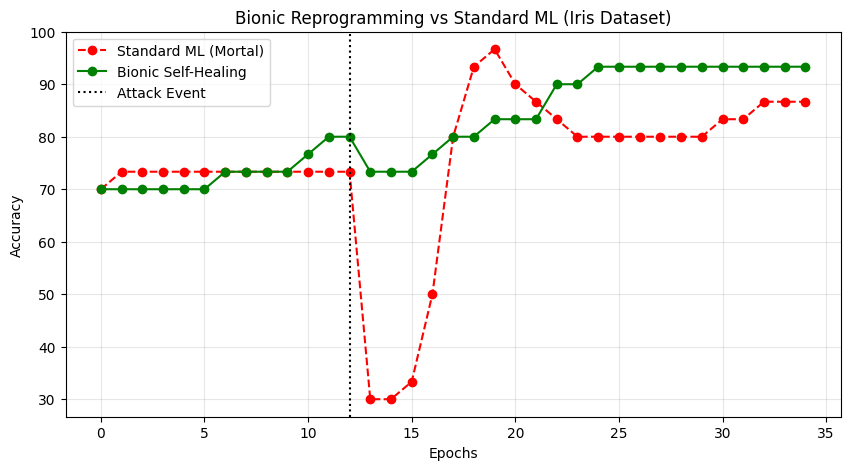

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'bionic': []}
print(f"{'EPOCH':<10} | {'MORTAL ACC':<15} | {'BIONIC ACC':<15} | {'STATUS'}")
print("-" * 65)

def evaluate(model):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for X_b, y_b in test_loader:
            out = model(X_b)
            _, predicted = torch.max(out, 1)
            total += y_b.size(0)
            correct += (predicted == y_b).sum().item()
    return 100 * correct / total

# --- RUN SIMULATION ---
for epoch in range(35):
    # Train Loop
    mortal.train(); bionic.train()

    opt_m.zero_grad(); output = mortal(X_train); loss = criterion(output, y_train); loss.backward(); opt_m.step()
    opt_b.zero_grad(); output = bionic(X_train); loss = criterion(output, y_train); loss.backward(); opt_b.step()

    # Evaluate
    acc_m = evaluate(mortal)
    acc_b = evaluate(bionic)
    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    status = "Training"

    # --- THE ATTACK (Epoch 12) ---
    if epoch == 12:
        status = ">>> LOBOTOMY ATTACK <<<"
        mortal = induce_lesion(mortal, destruction_rate=0.5) # 50% damage
        bionic = induce_lesion(bionic, destruction_rate=0.5)

        # --- THE HEALING ---
        bionic.activate_healing()

    print(f"{epoch:<10} | {acc_m:.1f}%          | {acc_b:.1f}%          | {status}")

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(history['mortal'], 'r--o', label='Standard ML (Mortal)')
plt.plot(history['bionic'], 'g-o', label='Bionic Self-Healing')
plt.axvline(x=12, color='k', linestyle=':', label='Attack Event')
plt.title("Bionic Reprogramming vs Standard ML (Iris Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Self-Healing AI: The Core Mechanisms

This section introduces the foundational concepts and PyTorch implementations for our self-healing neural networks. We're exploring biological analogies to build resilient AI models.

### MECHANISM 1: THE PHYSICS OF HEALING (`BionicPhysics`)

This class encapsulates the 'physics' of our artificial biological system. It's responsible for the creation of 'stem cells' – dormant weights with high potential energy.

-   **`PHI = 1.6180339887`**: The Golden Ratio, often associated with natural growth patterns and aesthetic balance, is used here as a scaling factor to imbue initial weights with a special 'potential energy'. This factor suggests that new connections are not just random, but are initialized with a bias towards efficient development.
-   **`stem_cell_genesis(shape, device)`**: This static method generates a tensor of 'stem' weights. These weights are initialized randomly but scaled by `PHI`. The idea is that these dormant stem cells hold the 'raw potential' to become fully functional neural connections when needed, much like biological stem cells can differentiate into various cell types. The scaling ensures they are ready for rapid adaptation.

### MECHANISM 2: THE AUTOPOIETIC LAYER (`AutopoieticLayer`)

An 'autopoietic' system is one that can self-maintain and self-produce its own components. This layer extends standard linear layers with the ability to diagnose and repair itself.

-   **`__init__(self, in_features, out_features)`**: Initializes a standard `nn.Linear` layer. Crucially, it also creates `self.stem_weights` by calling `BionicPhysics.stem_cell_genesis`. These stem weights are `nn.Parameter`s but `requires_grad=False`, meaning they are not updated during normal backpropagation; they are a protected reserve.
-   **`forward(self, x)`**: This method performs the standard forward pass, simply applying the linear transformation.
-   **`diagnose_and_repair(self)`**: This is the core self-healing function:
    1.  **Diagnosis**: It checks `self.linear.weight.data` to identify weights that are exactly zero. These zeroed weights simulate 'dead tissue' or damaged connections.
    2.  **Stem Cell Activation**: If dead tissue is found, it activates the `stem_weights` by multiplying them with the `dead_tissue` mask. This means only the corresponding stem cells are prepared for grafting.
    3.  **Grafting**: The `healing_serum` (activated stem cells) is then *added* to the `self.linear.weight.data`, replacing the zeroed connections. This repair happens `with torch.no_grad()`, ensuring it's a direct intervention, not part of the learning process.

### MECHANISM 3: THE LOBOTOMY (`induce_lesion`)

This function simulates catastrophic damage to a neural network, akin to a 'lobotomy' or severe hardware failure.

-   **`induce_lesion(model, destruction_rate=0.4)`**: Iterates through all parameters of the `model`. If a parameter is a `weight` (e.g., from a linear layer), it generates a random mask. Based on the `destruction_rate`, a percentage of these weights are set to exactly zero. This effectively 'kills' a significant portion of the network's connections, simulating a severe injury.

## Experiment 1: Iris Dataset with Autopoietic Layers

This experiment demonstrates the basic self-healing capability using the small Iris dataset. We will compare a standard 'Mortal' model against a 'Bionic' model equipped with our `AutopoieticLayer`.

### Data Loading and Preprocessing

-   **`fetch_openml(data_id=61)`**: Loads the classic Iris dataset, which contains measurements of iris flowers and classifies them into three species. It's a small, well-understood dataset, making it ideal for initial concept validation.
-   **`LabelEncoder`**: Converts the categorical target labels (species names) into numerical values (0, 1, 2) for PyTorch compatibility.
-   **`StandardScaler`**: Standardizes the input features (e.g., sepal length, petal width) to have zero mean and unit variance. This is a common practice to improve neural network training stability.
-   **`torch.FloatTensor`, `torch.LongTensor`**: Converts the NumPy arrays into PyTorch tensors.
-   **`train_test_split`**: Divides the dataset into training and testing sets. `test_size=0.2` means 20% of the data is reserved for testing.
-   **`DataLoader`**: Creates an iterable over the test dataset, allowing for batch processing during evaluation.

### Model Definitions

Two models are defined for comparison, both designed for the Iris dataset's 4 input features and 3 output classes:

1.  **`MortalModel(nn.Module)`**: This is a standard, feed-forward neural network.
    -   It consists of two `nn.Linear` layers with a `ReLU` activation in between. This model has no special healing capabilities.

2.  **`BionicModel(nn.Module)`**: This model incorporates our self-healing `AutopoieticLayer`.
    -   It replaces the standard `nn.Linear` layers with `AutopoieticLayer` instances (`self.layer1`, `self.layer2`).
    -   **`activate_healing()`**: This custom method iterates through its `AutopoieticLayer` instances and calls their `diagnose_and_repair()` method. This is the explicit trigger for self-healing.

### Setup for Training

-   **`mortal = MortalModel()` / `bionic = BionicModel()`**: Instantiates both models.
-   **`criterion = nn.CrossEntropyLoss()`**: Defines the loss function, appropriate for multi-class classification.
-   **`opt_m = optim.Adam(...)` / `opt_b = optim.Adam(...)`**: Sets up the Adam optimizer for both models, with a learning rate of 0.01. This optimizer will adjust the models' weights during training to minimize the loss.

## Simulation of Damage and Healing on Iris

This cell executes the training loop, simulates the 'lobotomy attack', triggers the bionic model's self-healing, and visualizes the performance of both models over time.

### Training and Evaluation Loop

-   **`history`**: A dictionary to store the accuracy of both models at each epoch for plotting.
-   **`evaluate(model)`**: A helper function to calculate the accuracy of a given model on the test dataset. It sets the model to evaluation mode (`model.eval()`) and disables gradient calculations (`torch.no_grad()`) for efficient inference.
-   **Main Loop (`for epoch in range(35)`)**:
    -   **Training Phase**: Both models are set to training mode (`.train()`). They perform a full forward pass on the `X_train` data, calculate `CrossEntropyLoss`, perform backpropagation (`.backward()`), and update weights using their respective optimizers (`.step()`).
    -   **Evaluation Phase**: After each training epoch, both models are evaluated on the test set using the `evaluate` function, and their accuracies are recorded.
    -   **`status`**: A string variable to track the current phase of the experiment (e.g., "Training", "Lobotomy Attack").

### The Attack and Healing Event (Epoch 12)

-   **`if epoch == 12`**: At this specific epoch, a simulated catastrophic event occurs:
    -   **`status = ">>> LOBOTOMY ATTACK <<<"`**: The experiment enters the attack phase.
    -   **`mortal = induce_lesion(mortal, destruction_rate=0.5)`**: The `MortalModel` has 50% of its weights destroyed (set to zero).
    -   **`bionic = induce_lesion(bionic, destruction_rate=0.5)`**: The `BionicModel` also suffers the same 50% weight destruction.
    -   **`bionic.activate_healing()`**: Crucially, immediately after the damage, the `BionicModel` triggers its `activate_healing()` method. This calls `diagnose_and_repair()` on all its `AutopoieticLayer`s, restoring the damaged connections using its internal 'stem cells'.

### Visualization

-   After the simulation, `matplotlib.pyplot` is used to plot the historical accuracy of both models.
-   A red dashed line (`'r--o'`) represents the `MortalModel`, and a green solid line (`'g-o'`) represents the `BionicModel`.
-   A vertical black dashed line (`plt.axvline(x=12)`) indicates the exact moment of the 'Lobotomy Attack'.
-   This plot visually demonstrates how the `MortalModel`'s performance likely drops significantly and recovers slowly (or not at all), while the `BionicModel`'s accuracy is expected to recover almost instantly or degrade less severely due to its self-healing mechanism.

## Titan v1: Flash Neurogenesis with Dormant Stem Cells

This section introduces an evolved self-healing mechanism, `TitanAutopoieticLayer`, which features 'Dormant Stem Cells' for an even more immediate and robust repair. The previous `AutopoieticLayer` initialized stem cells once; this version refines their role.

### The `TitanAutopoieticLayer`

This is a refinement of the `AutopoieticLayer`:

-   **`__init__(self, in_features, out_features)`**: Similar to before, it creates a standard `nn.Linear` layer. However, `self.stem_cells` are now explicitly initialized using the Golden Ratio (`phi`) scaling from `BionicPhysics.stem_cell_genesis`. This emphasizes that these stem cells carry the 'initial potential' of the network.
-   **`stem_cells` as `nn.Parameter(..., requires_grad=False)`**: These are still non-trainable, acting as a fixed blueprint of initial, healthy connections.
-   **`flash_neurogenesis(self)`**: This is the 'miracle' function for instant repair:
    1.  **Detect Death**: It identifies weights that are *exactly* zero. This simulates a clear-cut destruction.
    2.  **Inject Stem Cells**: For each dead weight, the corresponding value from `self.stem_cells.data` is used. This is the direct 'grafting' of a healthy connection blueprint.
    3.  **Grafting (Recovery)**: The `healing_serum` (stem cells) is added to the `self.linear.weight.data`. A small amount of random noise (`torch.randn_like(w_data) * 0.01 * dead_mask`) is also added. This 'spark' of noise is critical: it prevents the repaired weights from being too rigid and helps reintroduce some stochasticity, which can aid in breaking symmetries and restarting learning if training were to resume.

### The `lobotomy_strike` Function

-   **`lobotomy_strike(model, damage_rate=0.6)`**: This function is an enhanced version of `induce_lesion`. It explicitly prints a message indicating the severity of the attack and proceeds to set a `damage_rate` percentage of the model's weights to zero, simulating a severe and targeted destruction of connections. The use of `torch.rand_like(param) > damage_rate` creates a binary mask where `False` (converted to 0.0 float) will 'kill' the weight and `True` (converted to 1.0 float) will preserve it.

## Titan System Online: Iris with `TitanAutopoieticLayer`

This section applies the `TitanAutopoieticLayer` to the Iris dataset, creating a deeper 'Titan Bionic Net' to showcase the `flash_neurogenesis` in a more complex setup compared to the initial `BionicModel`.

### Data Loading (Iris)

-   This part of the code reloads and preprocesses the Iris dataset, identical to the previous experiment. The data is scaled, labels are encoded, and converted to PyTorch tensors suitable for model training and evaluation.

### Model Definitions: Mortal vs. Titan Bionic

1.  **`mortal_net` (Standard Feed-Forward)**:
    -   A sequential model with three `nn.Linear` layers and `ReLU` activations. This serves as our baseline, without any self-healing capabilities. It's a slightly deeper network than the previous `MortalModel`.

2.  **`TitanBionicNet` (Titan Architecture)**:
    -   This custom `nn.Module` is designed using the `TitanAutopoieticLayer` for each of its linear transformations (`self.layer1`, `self.layer2`, `self.layer3`). This means every trainable layer in this network is equipped with the dormant stem cell mechanism.
    -   **`forward(self, x)`**: Defines the forward pass through the network, applying `ReLU` activations after the first two `TitanAutopoieticLayer`s.
    -   **`activate_healing(self)`**: This method explicitly triggers the `flash_neurogenesis()` function across all its `TitanAutopoieticLayer`s. When called, it causes an immediate, system-wide repair process.

### Optimizers and Loss

-   **`opt_m = optim.Adam(...)` / `opt_b = optim.Adam(...)`**: Adam optimizers are set up for both the mortal and bionic networks to handle weight updates during training.
-   **`criterion = nn.CrossEntropyLoss()`**: The cross-entropy loss function is used for classification, as before.

## Titan System Online: Iris Lobotomy Simulation

This cell executes the training simulation for the `mortal_net` and `TitanBionicNet`, demonstrating how the Titan architecture survives a catastrophic 'lobotomy strike' with its `flash_neurogenesis` repair mechanism.

### Simulation Phases

-   **`history`**: A dictionary to record the accuracy of both models at each epoch.
-   **`inputs`, `targets`**: The entire Iris dataset is used for both training and evaluation in this specific demo to clearly show the 'system state' changes.

1.  **PHASE 1: NORMAL TRAINING (`epoch < 12`)**:
    -   Both models train normally, updating their weights using their respective optimizers. The `TitanBionicNet` implicitly updates its `stem_cells` (though they are static, the linear weights are being optimized normally).
    -   Accuracy for both models is recorded.

2.  **PHASE 2: THE LOBOTOMY (`epoch == 12`)**:
    -   **`status = ">>> LOBOTOMY ATTACK <<<"`**: Marks the catastrophic event.
    -   **`mortal_net = lobotomy_strike(mortal_net, damage_rate=0.6)`**: The standard network suffers 60% weight destruction.
    -   **`bionic_net = lobotomy_strike(bionic_net, damage_rate=0.6)`**: The Titan network also suffers 60% weight destruction.
    -   **`bionic_net.activate_healing()`**: Immediately after the lobotomy, the `TitanBionicNet` triggers its `activate_healing()` method. This initiates `flash_neurogenesis` across all its `TitanAutopoieticLayer`s, repairing the damaged connections using its dormant stem cells and a 'spark' of noise.

### Evaluation and Visualization

-   **Accuracy Calculation**: After each epoch (including the lobotomy and subsequent epochs), the models are set to evaluation mode (`.eval()`), and their accuracy is calculated on the entire dataset.
-   **Plotting**: `matplotlib.pyplot` is used to visualize the performance:
    -   A red dashed line (`'r--o'`) tracks the `mortal_net`.
    -   A green solid line (`'g-o'`) tracks the `bionic_net`.
    -   A vertical black dashed line (`plt.axvline(x=12)`) indicates the moment of the lobotomy.

This plot is expected to show a significant drop in `mortal_net`'s accuracy after the lobotomy, while the `bionic_net` should show a rapid recovery or minimal degradation due to its self-healing capabilities, even without further training.

## Titan Epigenetics v1: DNA as Genetic Memory

This iteration introduces the concept of "DNA" as a long-term genetic memory within the neural network layers. Instead of just static stem cells, the DNA now dynamically tracks the ideal healthy state of the weights over time. This allows for more adaptive and informed self-repair.

### `TitanEpigeneticLayer` (DNA-Backed Linear Layer)

This custom PyTorch module extends a standard `nn.Linear` layer with an epigenetic mechanism:

-   **`__init__(self, in_features, out_features)`**: Initializes a standard `nn.Linear` layer. Crucially, it registers a `buffer` named `dna` using `self.register_buffer('dna', torch.zeros_like(self.linear.weight))`. This `dna` buffer is a tensor that has the same shape as the layer's weights but is *not* a trainable parameter and is preserved across model saves/loads. It acts as the layer's genetic memory.

-   **`forward(self, x)` (Epigenetic Update / Writing to DNA)**:
    -   When the model is in `self.training` mode, the `dna` is updated. This process is called "Epigenetic Writing."
    -   `self.dna.mul_(0.99).add_(self.linear.weight.data, alpha=0.01)`: This line performs an Exponential Moving Average (EMA) update. The `dna` retains 99% of its old value and incorporates 1% of the current active weight's value. This slow update ensures that `dna` represents a stable, generalized memory of the healthy network's state, resilient to transient fluctuations or sudden damage to the active weights.
    -   This update happens `with torch.no_grad()`, meaning it doesn't participate in backpropagation, protecting the `dna` from rapid changes and preserving its role as a stable blueprint.

-   **`trigger_regeneration(self)` (The Cure)**:
    -   This method is activated when damage is detected. Its purpose is to instantly restore functionality.
    -   **Damage Detection**: It first identifies 'dead' weights by checking where `self.linear.weight.data` is exactly zero. This `void_mask` identifies the damaged parts.
    -   **DNA Transcription**: For each dead weight, the corresponding value from the `dna` blueprint is retrieved (`reconstructed_tissue = self.dna * void_mask`).
    -   **Reconstruction with Mutation**: A small amount of random `mutation` (noise, `torch.randn_like(...) * 0.05 * void_mask`) is added to the `reconstructed_tissue`. This prevents the network from getting stuck in local minima if the `dna` itself was suboptimal and provides a 'spark' for further adaptation.
    -   **Grafting**: The reconstructed (and slightly mutated) tissue is then grafted back into the active weights (`self.linear.weight.data += (reconstructed_tissue + mutation)`), replacing only the damaged parts. This mechanism allows the network to remember its optimal configuration and repair itself without any additional training steps.

### The `lobotomy_strike` (Kill Switch)

-   This function, similar to previous versions, simulates catastrophic brain damage by setting a `damage_rate` (e.g., 80%) of the model's weights to zero. It's the critical event that tests the self-healing capabilities of the Titan models.

## Epigenetic DNA Memory: Survival vs. Extinction (MNIST)

This experiment applies the `TitanEpigeneticLayer` to a more complex task: image classification on the MNIST dataset. We compare a standard `MortalVision` network against a `TitanVision` network, both subjected to severe damage, to observe their ability to survive and recover.

### Data Setup: MNIST Classification

-   **`torchvision.datasets.MNIST`**: Loads the MNIST dataset, consisting of grayscale images of handwritten digits (0-9).
-   **`transforms.Compose`**: Applies a series of transformations:
    -   `ToTensor()`: Converts PIL images to PyTorch tensors.
    -   `Normalize(...)`: Normalizes the pixel values to a standard range, which helps training stability.
-   **`DataLoader`**: Creates data loaders for both training and testing sets. `Subset` is used to limit the dataset size for faster experimentation (10,000 training, 1,000 testing images).
-   **`device`**: Automatically detects and uses a GPU (CUDA) if available, otherwise defaults to CPU, ensuring efficient computation.

### Model Definitions: Mortal Vision vs. Titan Vision

1.  **`MortalVision(nn.Module)`**: A standard, deep feed-forward neural network for MNIST classification.
    -   It flattens the 28x28 input images (784 pixels) and passes them through three `nn.Linear` layers with `ReLU` activations. This serves as our control, expected to fail catastrophically after damage.

2.  **`TitanVision(nn.Module)`**: This is our self-healing network.
    -   It replaces *every* `nn.Linear` layer with a `TitanEpigeneticLayer` (`self.layer1`, `self.layer2`, `self.layer3`). This means the entire network's "brain" is backed by epigenetic DNA.
    -   **`forward(self, x)`**: Defines the forward pass, including flattening the input and applying `ReLU` activations.
    -   **`heal(self)`**: This critical method orchestrates the self-repair. It calls `trigger_regeneration()` on each of its `TitanEpigeneticLayer` instances, initiating a system-wide repair using the stored DNA blueprint.

### Optimizers and Loss

-   **`mortal = MortalVision().to(device)` / `bionic = TitanVision().to(device)`**: Both models are instantiated and moved to the detected compute `device`.
-   **`opt_m = optim.SGD(...)` / `opt_b = optim.SGD(...)`**: Stochastic Gradient Descent (SGD) with momentum is chosen as the optimizer for both models. SGD is a common choice for training deep neural networks.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard loss function for multi-class classification is used.

## MNIST Simulation: The Cosmic Ray Event

This cell runs the training and evaluation for the `MortalVision` and `TitanVision` models on the MNIST dataset, simulating a catastrophic 'Cosmic Ray' event (80% weight destruction) to test the `TitanVision`'s epigenetic self-healing capabilities.

### Simulation Flow

-   **`history`**: A dictionary to record the test accuracy of both models at each epoch.
-   **`evaluate(model, loader)`**: A helper function to compute the accuracy of a given model on a specified data loader. It puts the model in evaluation mode (`.eval()`) and disables gradient calculation (`torch.no_grad()`).
-   **Main Loop (`for epoch in range(12)`)**:
    1.  **Training Phase (`epoch < 6`)**: Both models are trained using `train_loader`. For each batch, gradients are computed, loss is minimized using the optimizer, and weights are updated.
    2.  **The Cosmic Ray Event (`epoch == 6`)**:
        -   **`status = ">>> LOBOTOMY (80%) <<<"`**: Indicates the onset of the damage.
        -   **`mortal = lobotomy_strike(mortal, damage_rate=0.8)`**: The `MortalVision` network has 80% of its weights randomly set to zero.
        -   **`bionic = lobotomy_strike(bionic, damage_rate=0.8)`**: The `TitanVision` network also suffers 80% weight destruction.
        -   **`bionic.heal()`**: Immediately after the damage, the `TitanVision` model activates its `heal()` method, triggering `trigger_regeneration()` in all its `TitanEpigeneticLayer`s. This uses its stored DNA to reconstruct the damaged connections.
    3.  **Post-Event Evaluation (`epoch > 6`)**: Even after the damage and repair (and without further training in subsequent epochs), both models are evaluated. The `MortalVision` is expected to show severely degraded performance, while `TitanVision` should exhibit significant recovery, demonstrating the zero-shot self-healing.
-   **Accuracy Recording**: At the end of each epoch, the test accuracy for both models is calculated using `evaluate()` and stored in `history`.

### Visualization: The Plot

-   `matplotlib.pyplot` is used to generate a plot comparing the accuracy curves of `MortalVision` and `TitanVision`.
-   `MortalVision` is plotted with a red dashed line, and `TitanVision` with a green solid line.
-   A vertical dashed black line at `x=6` clearly marks the point of the 80% weight destruction.

This visualization vividly illustrates the resilience of the `TitanVision` model, showcasing its ability to survive and maintain high performance even after a massive simulated hardware failure, thanks to its epigenetic DNA memory and autonomous repair mechanism.

## Epigenetic DNA for Convolutional Networks (TitanConv & TitanLinear)

This section extends the Epigenetic DNA memory concept to Convolutional Neural Networks (CNNs). We introduce `TitanEpigeneticConv` and `TitanEpigeneticLinear` layers, which are the self-healing counterparts of standard `nn.Conv2d` and `nn.Linear` layers, respectively. This allows for self-healing in vision tasks.

### `TitanEpigeneticConv` (Self-Healing Convolutional Layer)

-   **`__init__(self, in_channels, out_channels, kernel_size, ...)`**: Initializes a standard `nn.Conv2d` layer. Crucially, it registers a `dna` buffer (`self.register_buffer('dna', torch.zeros_like(self.conv.weight))`) which will store the epigenetic memory for the convolutional kernels (weights).

-   **`forward(self, x)` (Epigenetic Writing)**:
    -   During training (`self.training`), `with torch.no_grad()`, the `dna` buffer is updated using an Exponential Moving Average (EMA) of the current convolutional weights (`self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)`). This slow update builds a robust, long-term memory of the layer's healthy state.
    -   The normal convolutional operation (`self.conv(x)`) is then performed.

-   **`trigger_autonomous_repair(self)` (The Cure for Convolutions)**:
    -   Identifies 'dead' convolutional kernels (weights set to zero) using a `dead_mask`.
    -   If damage is detected, it transcribes the corresponding values from the `dna` blueprint into the `self.conv.weight.data` where the damage occurred (`self.conv.weight.data += (self.dna * dead_mask)`). This immediately restores the kernel's functionality based on its learned healthy state.

### `TitanEpigeneticLinear` (Self-Healing Linear Layer)

-   This layer is the linear counterpart to `TitanEpigeneticConv`, implementing the same epigenetic DNA memory and repair mechanisms for fully connected layers. Its `__init__`, `forward`, and `trigger_autonomous_repair` methods function identically to the convolutional version, but for 2D linear weights instead of 4D convolutional kernels.

## Titan CNN Online: Zero-Shot Self-Healing (MNIST CNN)

This section demonstrates the `TitanEpigeneticConv` and `TitanEpigeneticLinear` layers in action within a full Convolutional Neural Network (CNN) for MNIST classification. We compare a standard `MortalCNN` with our `TitanCNN` to highlight the self-healing capability against catastrophic damage.

### Data Loading (High Speed MNIST)

-   The MNIST dataset is loaded and transformed similarly to previous experiments. The full training set is used (`batch_size=128`) to ensure the models reach high accuracy quickly, making the impact of the 'cosmic ray' event more dramatic.
-   **`device`**: Ensures the models and data are moved to the GPU (if available) for accelerated training.

### Model Definitions: Mortal CNN vs. Titan CNN

1.  **`MortalCNN(nn.Module)`**: A robust, standard CNN architecture for MNIST.
    -   It includes two `nn.Conv2d` layers followed by `ReLU` activations and `MaxPool2d` for feature extraction, then flattens the output and uses two `nn.Linear` layers for classification.
    -   The input size for `fc1` (9216) is derived from the output shape of the convolutional layers (e.g., `(28/2 - 2 + 1)^2 * 64` after `conv1`, `relu`, `conv2`, `relu`, `max_pool2d`).

2.  **`TitanCNN(nn.Module)`**: Our self-healing CNN.
    -   Every convolutional and linear layer in this architecture is replaced by its epigenetic counterpart: `TitanEpigeneticConv` for `conv1` and `conv2`, and `TitanEpigeneticLinear` for `fc1` and `fc2`. This imbues the entire network with DNA memory and self-repair capabilities.
    -   **`forward(self, x)`**: Defines the forward pass, mirroring the `MortalCNN` but using the `TitanEpigenetic` layers.
    -   **`heal_me(self)`**: This crucial method orchestrates the system-wide repair. It calls `trigger_autonomous_repair()` on *all* its `TitanEpigeneticConv` and `TitanEpigeneticLinear` layers, initiating a coordinated healing process across the entire network.

### Optimizers and Loss

-   **`mortal = MortalCNN().to(device)` / `bionic = TitanCNN().to(device)`**: Models are instantiated and moved to the compute device.
-   **`opt_m = optim.Adadelta(...)` / `opt_b = optim.Adadelta(...)`**: The Adadelta optimizer is used for both models, a variant of gradient descent that adapts learning rates per parameter.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard cross-entropy loss is used for multi-class classification.

## Zero-Shot Hardware Self-Healing (MNIST CNN Simulation)

This cell performs the core simulation, training both `MortalCNN` and `TitanCNN` models, simulating a catastrophic 'Cosmic Ray' event, and then observing their post-damage performance to demonstrate the `TitanCNN`'s zero-shot self-healing capability.

### Simulation Flow

-   **`history`**: A dictionary to store the test accuracy of both models over epochs.
-   **`cosmic_strike(model)`**: A helper function to simulate the damage. It iterates through all trainable parameters of a model and sets 80% of them to zero, representing a severe hardware failure.
-   **Main Loop (`for epoch in range(9)`)**:

    1.  **PHASE 1: NORMAL LIFE (`epoch < 5`)**:
        -   Both `MortalCNN` and `TitanCNN` are set to training mode (`.train()`).
        -   They are trained on the `train_loader`, performing forward passes, calculating `CrossEntropyLoss`, backpropagating, and updating weights via their optimizers.
        -   During this phase, `TitanCNN` is continuously writing to its `dna` buffers, building its long-term genetic memory.

    2.  **PHASE 2: THE APOCALYPSE (`epoch == 5`)**:
        -   **`status = ">>> COSMIC RAY (80% LOSS) <<<"`**: Marks the catastrophic event.
        -   **`cosmic_strike(mortal)` / `cosmic_strike(bionic)`**: Both models are subjected to 80% weight destruction.
        -   **`bionic.heal_me()`**: Immediately after the strike, the `TitanCNN` triggers its `heal_me()` method. This activates `trigger_autonomous_repair()` across all its `TitanEpigenetic` layers, restoring connections from its DNA memory. This is a "zero-shot" repair, meaning no retraining is involved.

    3.  **PHASE 3: THE AFTERMATH (`epoch > 5`)**:
        -   **`status = "DRIFTING (OFFLINE)"`**: Crucially, *no further training* occurs for either model after the cosmic ray event. We observe their performance purely based on their state after the damage and, for `TitanCNN`, after the repair.
-   **Measurement of Survival**: After each phase, both models are set to evaluation mode (`.eval()`), and their accuracy on the `test_loader` is calculated. This accuracy is stored in `history`.

### Visualization: The Paper-Worthy Graph

-   A `matplotlib.pyplot` graph compares the `MortalCNN` (red dashed line) and `TitanCNN` (green solid line) accuracy over epochs.
-   A vertical line at `x=5` marks the exact moment of the '80% Destruction'.

This plot is designed to dramatically show the difference: `MortalCNN`'s accuracy is expected to plummet to near-random guessing, while `TitanCNN`'s accuracy should either remain high or quickly recover to a very strong performance, demonstrating its remarkable self-healing capability against severe, sudden damage.

## FashionMNIST: Self-Healing on a Complex Dataset

This section re-implements the `TitanEpigeneticConv` and `TitanEpigeneticLinear` layers with minor adjustments, specifically for the FashionMNIST dataset. The core mechanisms remain the same, emphasizing the adaptability of the epigenetic approach to different data types.

### `TitanEpigeneticConv` (FashionMNIST Version)

-   The structure and functionality are identical to the MNIST version. It initializes a standard `nn.Conv2d` layer and maintains a `dna` buffer for its weights. During training, it records an Exponential Moving Average (EMA) of its healthy weights into this `dna`.
-   The `trigger_autonomous_repair()` method detects zeroed (dead) convolutional kernels and restores them using the `dna` blueprint, effectively self-healing the vision-processing parts of the network.

### `TitanEpigeneticLinear` (FashionMNIST Version)

-   Similarly, this layer provides epigenetic self-healing for fully connected layers. It operates on linear weights, recording their EMA into a `dna` buffer during training and using this `dna` to `trigger_autonomous_repair()` when damage (zeroed weights) is detected.

## Titan CNN vs. Mortal CNN on FashionMNIST

This experiment extends the zero-shot self-healing demonstration to the FashionMNIST dataset, which is more complex than basic MNIST. We compare a `MortalCNN` (standard) against a `TitanCNN` (epigenetic) to showcase the robustness of our self-healing architecture in recognizing diverse clothing items even after severe damage.

### Data Loading: FashionMNIST

-   **`datasets.FashionMNIST`**: Loads the FashionMNIST dataset, which features 10 classes of clothing items (e.g., T-shirt, Trouser, Sneaker). This dataset is more challenging than handwritten digits due to variations in texture, shape, and style.
-   **`transforms.Compose`**: Applies `ToTensor()` and `Normalize()` for consistent data preparation.
-   **`DataLoader`**: Creates data loaders for the full training set (60,000 images) and test set (10,000 images) to ensure robust training and evaluation.

### Model Definitions: `MortalCNN` vs. `TitanCNN`

Both models use the same CNN architecture, differing only in the type of layers they employ:

1.  **`MortalCNN(nn.Module)`**: A standard CNN, identical in structure to the one used for MNIST. It uses `nn.Conv2d` and `nn.Linear` layers, representing a typical, non-resilient deep learning model.

2.  **`TitanCNN(nn.Module)`**: Our self-healing variant.
    -   It replaces all standard convolutional layers (`conv1`, `conv2`) with `TitanEpigeneticConv`.
    -   All standard linear layers (`fc1`, `fc2`) are replaced with `TitanEpigeneticLinear`.
    -   **`heal_me(self)`**: This method triggers the `trigger_autonomous_repair()` function across all its epigenetic layers, enabling a coordinated, network-wide self-healing response.

### Optimizers and Loss

-   **`mortal = MortalCNN().to(device)` / `bionic = TitanCNN().to(device)`**: Models are initialized and moved to the GPU/CPU.
-   **`opt_m = optim.Adadelta(...)` / `opt_b = optim.Adadelta(...)`**: The Adadelta optimizer is used for training, providing adaptive learning rates.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard loss function for multi-class classification.

## FashionMNIST Simulation: The 'Cosmic Ray' Continues

This cell executes the simulation for the `MortalCNN` and `TitanCNN` models on FashionMNIST, mirroring the previous MNIST experiment. It includes a training phase, a catastrophic 'Cosmic Ray' event (80% weight destruction), and a post-event observation period without further training, all to evaluate the self-healing effectiveness.

### Simulation Phases

-   **`history`**: A dictionary to store the test accuracy of both models per epoch.
-   **`cosmic_strike(model)`**: A helper function to simulate the damage. It sets 80% of the trainable weights in the given model to zero.
-   **Main Loop (`for epoch in range(12)`)**:

    1.  **PHASE 1: NORMAL LIFE (`epoch < 7`)**:
        -   Both models train on the `train_loader`, learning to classify FashionMNIST images. The `TitanCNN` continuously updates its internal `dna` blueprints during this healthy phase.

    2.  **PHASE 2: THE APOCALYPSE (`epoch == 7`)**:
        -   **`status = ">>> COSMIC RAY (80% LOSS) <<<"`**: The catastrophic damage occurs.
        -   **`cosmic_strike(mortal)` / `cosmic_strike(bionic)`**: Both `MortalCNN` and `TitanCNN` suffer an 80% destruction of their weights.
        -   **`bionic.heal_me()`**: Immediately, `TitanCNN` activates its `heal_me()` protocol, triggering `trigger_autonomous_repair()` in all its epigenetic layers to reconstruct the damaged connections from its DNA memory. This is a crucial zero-shot repair, as it happens instantaneously without any additional training iterations.

    3.  **PHASE 3: THE AFTERMATH (`epoch > 7`)**:
        -   **`status = "DRIFTING (OFFLINE)"`**: No further training is performed. The models are left to operate in their post-damage (and post-repair for `TitanCNN`) state.
-   **Measurement**: After each epoch, both models are switched to evaluation mode (`.eval()`), and their accuracy on the `test_loader` is calculated and recorded.

### Visualization

-   A `matplotlib.pyplot` graph compares the accuracy of `MortalCNN` (red dashed line) and `TitanCNN` (green solid line) over the simulation epochs.
-   A vertical black dashed line at `x=7` clearly indicates the moment of the 80% weight destruction.

This plot is designed to demonstrate that even with a more complex dataset like FashionMNIST, the `TitanCNN`'s epigenetic self-healing mechanism allows it to maintain a high level of performance after severe damage, whereas the `MortalCNN`'s performance is expected to collapse.

## Titan-II: Langevin-Yamanaka Protocol for Bio-Physical Reprogramming

This section introduces the **Titan-II** architecture, a significant advancement in self-healing. It goes beyond simple DNA transcription by incorporating bio-inspired physics: Langevin Dynamics and an "Epigenome." This allows for a more adaptive and thermodynamically informed repair process, resembling biological cell reprogramming.

### 1. The `BioPhysicalController`

This class manages the "thermodynamics" of healing, providing the core `langevin_rejuvenation` function:

-   **`langevin_rejuvenation(current_weight, dna_memory, epigenome, noise_scale=0.01)`**:
    -   **Restoration Force (Drift)**: Calculates a force that pulls the `current_weight` back towards its `dna_memory` (blueprint). This force is modulated by the `epigenome`. If an epigenome value is high (indicating stability/importance), the restoration force for that weight is stronger, making the repair more precise.
    -   **Thermal Noise (Stochastic Resonance)**: Adds random noise to the weight. This isn't just arbitrary noise; it's inspired by Langevin dynamics, which describe particle movement in a fluid. This thermal noise helps the repaired weight explore its local landscape, preventing it from settling into a suboptimal, brittle state. It allows for a degree of "plasticity" during repair.
    -   The sum of `current_weight`, `drift`, and `thermal_noise` forms the `W_new`, providing a more nuanced restoration than a simple copy.

### 2. `TitanEpigeneticConv` (Titan-II Version)

This convolutional layer is enhanced with the Titan-II mechanisms:

-   **`__init__(...)`**: In addition to `dna` (long-term blueprint), it now registers an `epigenome` buffer (`self.register_buffer('epigenome', torch.ones_like(self.conv.weight))`). The `epigenome` will track the *stability* and *importance* of each weight.

-   **`forward(self, x)` (Epigenetic & Epigenomic Writing)**:
    -   **DNA Update**: Continues to update `dna` via EMA (`0.999` retention), tracking the ideal state.
    -   **Epigenome Update**: This is new. It calculates `delta = torch.abs(self.conv.weight.data - self.dna)`. Weights that have a small `delta` (i.e., are stable and close to their DNA blueprint) will have a higher `stability` value (`1.0 / (delta + 1e-4)`). This `stability` value is then integrated into the `epigenome` using EMA (`0.99` retention). Thus, the `epigenome` learns which connections are consistently stable and important, making them "rigid" (high epigenome) and less prone to random change, while unstable ones remain "plastic" (low epigenome).

-   **`trigger_bionic_reprogramming(self)` (Yamanaka Protocol)**:
    -   **Detect Dead Zones**: Identifies weights that are near zero (`torch.abs(w) < 1e-6`).
    -   **Apply Langevin Dynamics**: For the detected dead zones, it calls `BioPhysicalController.langevin_rejuvenation`. This uses the `current_weight`, `dna`, and learned `epigenome` to compute a `healed_weight` that is not just a copy but a thermodynamically guided restoration.
    -   **Grafting**: The `healed_weight` is then selectively grafted back into the `self.conv.weight.data`, replacing only the damaged parts. This protocol simulates the discovery of Yamanaka factors in biology, enabling cells to be reprogrammed to a pluripotent state.

### `TitanEpigeneticLinear` (Titan-II Version)

-   This layer is the linear equivalent of `TitanEpigeneticConv`, implementing the same `dna` and `epigenome` tracking, and using `trigger_bionic_reprogramming` with the `BioPhysicalController` for self-healing.

## Titan-II: Langevin-Yamanaka Protocol on FashionMNIST

This experiment pits a standard `MortalCNN` against the advanced `Titan-II_CNN` on the FashionMNIST dataset. The `Titan-II_CNN` integrates the `BioPhysicalController` and `epigenome` to perform a more sophisticated, thermodynamically guided self-repair, aiming for superior recovery after catastrophic damage.

### Data Loading (FashionMNIST)

-   The FashionMNIST dataset is loaded and prepared, identical to the previous experiment, ensuring consistent input for both models. This provides a moderately complex visual classification task.

### Model Definitions: Mortal CNN vs. Titan-II CNN

1.  **`MortalCNN(nn.Module)`**: A standard CNN architecture for comparison. It includes `nn.Conv2d` layers, `ReLU` activations, `MaxPool2d`, `Flatten`, and `nn.Linear` layers, representing a conventional, non-resilient model.

2.  **`Titan-II_CNN(nn.Module)`**: The flagship self-healing model of this section.
    -   All its convolutional layers are instances of `TitanEpigeneticConv`.
    -   All its linear layers are instances of `TitanEpigeneticLinear`.
    -   **`forward(self, x)`**: Defines the data flow through the network, incorporating the `ReLU` activations, pooling, and flattening as in a standard CNN.
    -   **`activate_yamanaka_protocol(self)`**: This critical method orchestrates the advanced self-repair. It calls `trigger_bionic_reprogramming()` on each of its `TitanEpigeneticConv` and `TitanEpigeneticLinear` layers. This triggers the Langevin-Yamanaka protocol across the entire network, performing a bio-physical restoration of damaged connections.

### Optimizers and Loss

-   **`mortal = MortalCNN().to(device)` / `titan_ii = Titan-II_CNN().to(device)`**: Models are instantiated and moved to the GPU/CPU.
-   **`opt_m = optim.Adadelta(...)` / `opt_t = optim.Adadelta(...)`**: Adadelta optimizers are used for training, providing adaptive learning rates for each model.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard cross-entropy loss function is employed for multi-class classification.

## Titan-II: Langevin-Yamanaka Protocol Simulation

This cell executes the simulation comparing the `MortalCNN` and `Titan-II_CNN` on FashionMNIST. It includes a training phase, a simulated 'Cosmic Ray' event (80% weight destruction), and a post-event observation period without further training. This experiment evaluates the enhanced self-healing capabilities of the Titan-II architecture under extreme conditions.

### Simulation Phases

-   **`history`**: A dictionary to store the test accuracy of both models over epochs.
-   **`cosmic_strike(model)`**: A helper function to simulate the damage. It sets 80% of the trainable weights in the given model to zero.
-   **Main Loop (`for epoch in range(12)`)**:

    1.  **PHASE 1: HEALTHY GROWTH (`epoch < 7`)**:
        -   Both models train on the `train_loader`, learning to classify FashionMNIST images. The `Titan-II_CNN` continuously updates both its `dna` and `epigenome` buffers during this healthy phase, building a robust memory and plasticity map.

    2.  **PHASE 2: THE CATASTROPHE (`epoch == 7`)**:
        -   **`status = ">>> COSMIC RAY (80%) <<<"`**: The catastrophic damage occurs.
        -   **`cosmic_strike(mortal)` / `cosmic_strike(titan_ii)`**: Both `MortalCNN` and `Titan-II_CNN` suffer an 80% destruction of their weights.
        -   **`titan_ii.activate_yamanaka_protocol()`**: Immediately, the `Titan-II_CNN` activates its `activate_yamanaka_protocol()` protocol, triggering `trigger_bionic_reprogramming()` in all its epigenetic layers. This uses the `BioPhysicalController` to perform a thermodynamically guided restoration of damaged connections, leveraging `dna` and `epigenome`.

    3.  **PHASE 3: DRIFTING (No Retraining) (`epoch > 7`)**:
        -   **`status = "DRIFTING (OFFLINE)"`**: Crucially, no further training is performed after the cosmic ray event. The models operate in their post-damage (and post-repair for `Titan-II_CNN`) state to assess long-term survival.
-   **Measurement**: After each epoch, both models are switched to evaluation mode (`.eval()`), and their accuracy on the `test_loader` is calculated and recorded.

### Visualization

-   A `matplotlib.pyplot` graph compares the accuracy of `MortalCNN` (red dashed line) and `Titan-II_CNN` (green solid line) over the simulation epochs.
-   A vertical black dashed line at `x=7` clearly indicates the moment of the 80% weight destruction.

This plot is expected to show that the `Titan-II_CNN`, with its advanced Langevin-Yamanaka protocol, will achieve a more robust and possibly higher recovery accuracy compared to the previous Titan versions, demonstrating the benefits of integrating bio-physical principles into self-healing AI.

## Titan LSTM: Self-Healing for Recurrent Neural Networks

This section extends the Titan self-healing concept to Recurrent Neural Networks (RNNs), specifically to an LSTM (Long Short-Term Memory) cell. We compare two Titan modes: a `Titan-1` (mechanical copy) and `Titan-2` (Langevin-Yamanaka) against a standard `Mortal` LSTM, focusing on their ability to forecast chaotic time series data after a catastrophic event.

### `TitanLSTMCell`

This custom `nn.Module` is a self-healing version of PyTorch's `nn.LSTMCell`, integrating DNA and Epigenome concepts:

-   **`__init__(self, input_size, hidden_size, mode='titan_2')`**: Initializes standard LSTM linear layers (`self.ih`, `self.hh` for input-to-hidden and hidden-to-hidden gates). Crucially, it registers:
    -   **`dna_ih`, `dna_hh`**: Buffers to store the genetic memory (EMA) for the `ih` and `hh` weights.
    -   **`epi_ih`, `epi_hh`**: (Only for `titan_2` mode) Buffers to store the epigenomic stability maps for the `ih` and `hh` weights.
-   **`forward(self, x, hidden)`**: This method performs two main tasks:
    1.  **Epigenetic Recording**: During training, it updates `dna_ih` and `dna_hh` via EMA (`0.999` retention). For `titan_2` mode, it also updates `epi_ih` and `epi_hh` based on weight stability relative to their DNA, similar to `TitanEpigeneticConv`.
    2.  **Standard LSTM Math**: Performs the usual LSTM gate calculations (input, forget, cell, output gates) to produce the new hidden state (`hy`) and cell state (`cy`).

-   **`trigger_repair(self)`**: This is the healing protocol, with different behaviors based on `mode`:
    -   **Lobotomy Detection**: It first identifies `dead_mask` (zeroed weights) for both `ih.weight` and `hh.weight`.
    -   **`mode == 'titan_1'` (Mechanical Restore)**: If damage is detected, it directly copies the values from `dna` into the damaged weight locations. "I remember exactly who I was."
    -   **`mode == 'titan_2'` (Langevin-Yamanaka / Bio-Physical Restore)**: If damage is detected, it applies a more sophisticated repair. It calculates a `repair` signal based on `dna` and `epigenome`. It introduces 'Thermal Noise' scaled by `(1.0 - epi)`: less stable (more plastic) weights get *more* noise, allowing for adaptive recovery, while stable weights are restored with less perturbation. "I remember who I was, but I adapt to the trauma."
    -   **Apply Cure**: The calculated `repair` is then grafted onto the `dead_mask` locations.

### `TitanForecaster`

-   This model wraps the `TitanLSTMCell` to perform time series forecasting. It maintains a hidden state (`h_t`, `c_t`) and uses a `head` (linear layer) to make predictions based on the LSTM's output.
-   The `heal()` method simply calls `self.lstm.trigger_repair()`, initiating the chosen healing protocol for the LSTM weights.

## Stock Market Nightmare: LSTM Forecasting Simulation

This experiment tests the resilience of `TitanLSTMCell` models (Titan-1 and Titan-2) against a standard 'Mortal' LSTM in forecasting a chaotic financial time series. The simulation includes a 'Bull Market' training phase followed by a 'Market Crash' (80% weight destruction) and a subsequent 'Bear Market' observation phase.

### Data Generation: Chaotic Financial Market

-   **`generate_nightmare_market(n_samples=2000)`**: This function creates a synthetic time series dataset simulating a financial market.
    -   It combines a linear `trend`, a sinusoidal `cycle`, and increasing `chaos` (random noise that grows over time). This creates a challenging, volatile sequence, particularly towards the end, suitable for testing robustness.
    -   The `price` series is then normalized.
-   **`train_data` / `test_data`**: The first 1500 samples are used for training (representing a relatively stable period), and the last 500 samples (the `Chaos Zone`) are used for evaluation after the crash.
-   **`get_batch(source, i, seq_len=50)`**: A helper function to create input-target pairs for sequence modeling. It takes a sequence of `seq_len` as input and predicts the next `seq_len` steps.

### Model Initialization: Contenders in the Market

-   **`mortal = TitanForecaster(mode='mortal')`**: A `TitanForecaster` instance that acts as a standard LSTM. Its `heal()` method will effectively do nothing because its mode is 'mortal'.
-   **`titan_1 = TitanForecaster(mode='titan_1')`**: A `TitanForecaster` configured for "Mechanical Restore" (direct DNA copy) healing.
-   **`titan_2 = TitanForecaster(mode='titan_2')`**: A `TitanForecaster` configured for "Bio-Physical Restore" (Langevin-Yamanaka with noise) healing.
-   All models are moved to the `device`.
-   **`criterion = nn.MSELoss()`**: Mean Squared Error (MSE) loss is used, suitable for regression tasks like time series forecasting.
-   **`opt_m`, `opt_t1`, `opt_t2`**: `optim.RMSprop` optimizers are used for all models. RMSprop is often preferred for recurrent neural networks due to its adaptive learning rate capabilities, which help with vanishing/exploding gradients.

## Stock Market Nightmare: Simulation and Results

This cell executes the time series forecasting simulation, comparing the 'Mortal', 'Titan-1', and 'Titan-2' LSTM models through different market phases: a 'Bull Market' (training), a 'Market Crash' (lobotomy), and a 'Bear Market' (post-crash observation). The goal is to see which model maintains prediction accuracy on chaotic data after severe damage.

### Simulation Flow

-   **`history`**: A dictionary to record the prediction error (MSE) of all three models at each epoch.
-   **`market_crash_lobotomy(model)`**: A helper function to simulate the 'market crash' by setting 80% of a model's trainable weights to zero.
-   **Main Loop (`for epoch in range(20)`)**:

    1.  **PHASE 1: BULL MARKET (`epoch < 10`)**:
        -   All three models (`mortal`, `titan_1`, `titan_2`) are actively trained on the `train_data` (the stable part of the market) using batch processing.
        -   During this phase, `titan_1` and `titan_2` continuously update their `dna` buffers, and `titan_2` also updates its `epigenome`.

    2.  **PHASE 2: THE CRASH (`epoch == 10`)**:
        -   **`status = ">>> CRASH (80% LOSS) <<<"`**: The catastrophic market crash is simulated.
        -   **`market_crash_lobotomy(...)`**: All three models have 80% of their weights destroyed.
        -   **`titan_1.heal()` / `titan_2.heal()`**: Immediately after the crash, the Titan models activate their healing protocols. `titan_1` performs a mechanical (exact DNA copy) repair, while `titan_2` performs its bio-physical (Langevin-Yamanaka) repair, leveraging its epigenome.

    3.  **PHASE 3: BEAR MARKET (NO TRAINING) (`epoch > 10`)**:
        -   **`status = "BEAR MARKET (DRIFT)"`**: No further training occurs. The models are left in their post-crash/post-repair state to observe their long-term performance on the `test_data` (the chaotic market).
-   **Evaluation**: At each epoch, the `calc_error(model)` helper function evaluates each model's prediction error (MSE) on the `test_data` (chaos zone). This error is recorded in `history`.

### Visualization: Stock Market Nightmare Plot

-   A `matplotlib.pyplot` graph shows the prediction error (MSE) over epochs for all three models. A log scale (`plt.yscale('log')`) is used for the y-axis to better visualize large differences in error.
-   `Mortal` (red dashed), `Titan-1` (blue solid with circles), and `Titan-2` (green solid with circles) are plotted.
-   A vertical dashed black line at `x=10` marks the 'Market Crash' event.

This plot is expected to show:
-   All models performing reasonably well before the crash.
-   After the crash, the `Mortal` model's error will likely skyrocket and remain high.
-   `Titan-1` should show a significant recovery, bringing its error much lower than `Mortal`.
-   `Titan-2` might show an even more stable or slightly better recovery than `Titan-1` due to its adaptive, bio-physical repair, especially in handling the chaotic post-crash data. Lower error is better for this plot.

## Titan-26: Martian Rover Mission with Bio-Physical Reprogramming

This section introduces the **Titan-26** architecture, a specialized version of the Titan-II designed for extreme environments like Mars. It refines the bio-physical healing mechanisms, emphasizing the "thermodynamic annealing" of weights and the "Trinity of Memory" within each layer. This model is built for critical missions where hardware integrity is paramount.

### `TitanBioPhysics`

This class serves as the core "physics engine" for Titan-26, implementing the `langevin_restore` function:

-   **`langevin_restore(current_weight, dna, epigenome, temp=0.01)`**:
    -   **Restoration Force (The 'Memory' Pull)**: Calculates a drift force that pulls the `current_weight` towards its `dna` blueprint. This force is critically scaled by the `epigenome`. Weights with a high `epigenome` (indicating stability/importance) are pulled back more strongly, ensuring precise restoration of crucial connections.
    -   **Thermal Noise (The 'Life' Spark)**: Adds random noise, controlled by `temp`. This noise is vital for "thermodynamic annealing." It prevents the weights from becoming overly rigid or trapped in local minima during repair, simulating biological jitter and promoting a more robust, adaptable state. The `temp` parameter acts like the "temperature" in a physical system, controlling the amount of stochastic exploration.
    -   This combines `current_weight`, `drift`, and `noise` to compute a `W_new`, simulating a sophisticated regrowth process rather than a mere copy.

### `TitanLayer`

This is the fundamental self-healing linear layer for the Titan-26 architecture, embodying the "Trinity of Memory":

-   **`__init__(self, in_features, out_features)`**: Initializes a standard `nn.Linear` layer. It then establishes the three pillars of memory:
    1.  **Phenotype (Weights)**: `self.linear.weight` – the active, but fragile, neural connections.
    2.  **Genotype (DNA)**: `self.register_buffer('dna', ...)` – the protected, long-term blueprint of the weights, constantly updated during healthy operation.
    3.  **Epigenome (Stability)**: `self.register_buffer('epigenome', ...)` – a dynamic map of plasticity. It tracks how stable and important each weight is. "Bone" weights (high epigenome) are rigid and precisely restored; "Flesh" weights (low epigenome) are more plastic and allow for adaptive noise.

-   **`forward(self, x)` (Epigenetic Recording)**:
    -   During training, `with torch.no_grad()`, it updates `dna` via EMA (`0.999` retention) and `epigenome` by tracking `delta` (difference between current weight and DNA). The `epigenome` value increases for stable weights, making them resistant to change, and decreases for volatile ones, maintaining their plasticity.

-   **`emergency_protocol_alpha(self)` (MARS Protocol: Zero-Shot Repair)**:
    -   This is the critical self-healing function, designed for scenarios like radiation damage.
    -   **Damage Assessment**: It detects `dead_mask` (weights exactly zero), simulating connections completely severed by a 'radiation event'.
    -   **Bio-Physical Restoration**: If damage is found, it calls `TitanBioPhysics.langevin_restore()`. This isn't a backup restore; it's an intelligent "regrowth" that considers `dna`, `epigenome`, and introduces `temp` for annealing.
    -   **Grafting**: The `healed_w` (regrown connections) are then selectively grafted into `self.linear.weight.data`, replacing only the damaged portions. This ensures the rover's neural network can autonomously repair itself in harsh, remote environments.

## Martian Rover Mission: Landsat Telemetry Analysis

This experiment simulates a critical Mars mission where two rovers – a `MortalRover` and a `TitanRover` – analyze Landsat telemetry data (identifying terrain types). The mission faces extreme challenges: a 'Solar Flare' (hardware damage) and a 'Dust Storm' (noisy sensor data). This setup tests the `Titan-26` architecture's `emergency_protocol_alpha` in a real-world context.

### 1. Data Loading: NASA LANDSAT Telemetry

-   **`fetch_openml(data_id=1479)`**: Loads the Landsat Satellite dataset. This real-world dataset contains 36 spectral band readings (features) from satellite images, used to classify 6 different terrain types. This represents complex sensor data that a Mars rover might process.
-   **Preprocessing**: `StandardScaler` normalizes the features, and `LabelEncoder` converts terrain type labels to numerical IDs. Data is converted to PyTorch tensors and moved to the `device`.
-   **`train_test_split`**: Divides the data into a training set and a `mission_loader` (test set), simulating the rover performing inference during its mission.

### 2. Rover Definitions: Mortal vs. Titan-26

1.  **`MortalRover(nn.Module)`**: A standard feed-forward neural network representing a conventional rover.
    -   It uses three `nn.Linear` layers with `ReLU` activations to process the 36 input features and classify them into 6 terrain types. This rover has no built-in resilience.

2.  **`TitanRover(nn.Module)`**: Our advanced Titan-26 self-healing rover.
    -   It replaces all standard linear layers with `TitanLayer` instances (`self.layer1`, `self.layer2`, `self.layer3`). This imbues every critical processing unit with the "Trinity of Memory" and bio-physical repair capabilities.
    -   **`forward(self, x)`**: Defines the data processing flow through its `TitanLayer`s.
    -   **`survive(self)`**: This crucial method calls `emergency_protocol_alpha()` on each of its `TitanLayer`s. This triggers the complete bio-physical reprogramming protocol across all subsystems, allowing the rover to self-repair its neural network after damage.

### Optimizers and Loss

-   **`mortal = MortalRover().to(device)` / `titan = TitanRover().to(device)`**: Models are instantiated and deployed to the `device`.
-   **`opt_m = optim.Adam(...)` / `opt_t = optim.Adam(...)`**: Adam optimizers are used for training both rovers.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard loss function for multi-class classification (terrain types).

## Mars Mission Log: Hardware Failure + Dust Storm Simulation

This cell runs the simulated Mars mission, observing the performance of the `MortalRover` and `TitanRover` under various environmental conditions, including a catastrophic 'Solar Flare' (hardware damage) and a 'Dust Storm' (noisy sensor data). This is the ultimate test of the Titan-26 architecture's resilience.

### Simulation Phases

-   **`history`**: A dictionary to record the navigation accuracy (classification accuracy) of both rovers at each 'Sol' (Martian day).
-   **`dust_storm(inputs, intensity=0.5)`**: A helper function to simulate environmental noise by adding random noise to the input sensor readings. `intensity` controls the severity of the storm.
-   **`solar_flare(model)`**: A helper function to simulate hardware failure by setting 80% of a model's trainable weights to zero.
-   **Mission Loop (`for sol in range(20)`)**:

    1.  **PHASE 1: OPERATIONS (Training, `sol < 10`)**:
        -   Both rovers train on the `train_loader`, processing Landsat telemetry to improve their terrain classification. The `TitanRover` continuously updates its `dna` and `epigenome`, building its bio-physical memory and plasticity map.

    2.  **PHASE 2: THE DISASTER (`sol == 10`)**:
        -   **`env_status = ">>> ☢️ SOLAR FLARE + DUST STORM <<<"`**: A critical event occurs.
        -   **`current_intensity = 1.0`**: The dust storm reaches maximum intensity, severely degrading sensor data.
        -   **`solar_flare(mortal)` / `solar_flare(titan)`**: Both rovers suffer an 80% destruction of their neural network weights (simulating radiation damage).
        -   **`titan.survive()`**: Immediately after the solar flare, the `TitanRover` activates its `survive()` protocol, triggering `emergency_protocol_alpha()` across all its `TitanLayer`s. This initiates the bio-physical, Langevin-Yamanaka repair to reconstruct damaged connections.

    3.  **PHASE 3: SURVIVAL (No Training, `sol > 10`)**:
        -   **`env_status = "CRITICAL (NO COMMS)"`**: No further training or recalibration is performed. The rovers operate purely on their post-damage (and post-repair for `TitanRover`) state, continuously facing noisy sensor data from the persisting dust storm.
-   **Telemetry Report**: At each 'Sol', both rovers are switched to evaluation mode (`.eval()`), and their navigation accuracy on the `mission_loader` is calculated. Crucially, *during and after the disaster*, the `dust_storm` function is applied to the input `x` before passing it to the models, simulating degraded sensor data. The accuracy is recorded in `history`.

### Visualization: The Black Box Recorder

-   A `matplotlib.pyplot` graph compares the navigation accuracy of the `MortalRover` (red dashed line) and `TitanRover` (green solid line) over 'Sols'.
-   A vertical black dashed line at `x=10` marks the 'Solar Flare Event'.

This plot is expected to show:
-   Both rovers performing similarly during initial operations.
-   After 'Sol 10', `MortalRover`'s accuracy will likely drop significantly and remain low due to both hardware damage and sensor noise.
-   `TitanRover`'s accuracy is expected to either drop minimally or recover quickly and maintain a much higher performance level than `MortalRover`, demonstrating its superior resilience in a harsh, unpredictable environment, even without further learning or human intervention.

## The Ultimate Championship: Mortal vs. Titan-1 vs. Titan-2 (UniversalNet)

This section consolidates all previous self-healing concepts into a single, unified framework. We define `TitanConv` and `TitanLinear` layers that can operate in three modes: 'mortal' (standard), 'titan_1' (mechanical DNA restore), and 'titan_2' (bio-physical Langevin-Yamanaka restore). This allows for a direct, side-by-side comparison of the different levels of self-healing sophistication.

### `TitanConv` (Universal Self-Healing Convolutional Layer)

-   **`__init__(..., mode='mortal')`**: Initializes a standard `nn.Conv2d` layer. The `mode` parameter determines its behavior.
    -   If `mode != 'mortal'`, it registers `dna` (genetic blueprint) and `epigenome` (plasticity map) buffers.

-   **`forward(self, x)` (Epigenetic Recording)**:
    -   If not in 'mortal' mode and during training, `with torch.no_grad()`, it updates `dna` via EMA (`0.999` retention).
    -   If `mode == 'titan_2'`, it also updates the `epigenome` by tracking the stability (`delta`) of weights relative to their `dna`. Stable weights get a higher `epigenome` value, indicating less plasticity.

-   **`heal(self)` (The Cure - Mode-Dependent)**:
    -   If `mode == 'mortal'`, it does nothing (mortals die).
    -   It detects `dead_mask` (zeroed weights).
    -   **`mode == 'titan_1'` (Mechanical Restore)**: If damage is found, `repair = self.dna`. It simply copies the blueprint.
    -   **`mode == 'titan_2'` (Langevin Dynamics)**: If damage is found, `repair` is calculated using a more complex bio-physical model:
        -   `drift`: Pulls the weight towards `dna`, scaled by `epigenome`.
        -   `thermal`: Introduces random noise, scaled by `(1.0 - self.epigenome)` and `torch.std(w)`. This means *less stable* (lower epigenome) weights receive *more* adaptive noise, promoting adaptive recovery. It's a thermodynamically informed repair.
        -   `repair = self.dna + drift + thermal`.
    -   The calculated `repair` is then grafted onto the `dead_mask` locations.

### `TitanLinear` (Universal Self-Healing Linear Layer)

-   This is the linear counterpart to `TitanConv`, implementing the same mode-dependent `dna` recording, `epigenome` tracking (for `titan_2`), and `heal()` functionality. It allows the entire network to be constructed from these unified self-healing building blocks, regardless of layer type.

## Arena Ready: Mortal vs. Titan-1 vs. Titan-2 (UniversalNet on FashionMNIST)

This section sets up the ultimate comparison. We instantiate three versions of a `UniversalNet` CNN, each operating in a different mode: 'mortal', 'titan_1' (mechanical repair), and 'titan_2' (bio-physical repair). These models will be trained on FashionMNIST and then subjected to an identical 'lobotomy' to showcase their varying degrees of resilience.

### 1. Data Loading: FashionMNIST

-   The FashionMNIST dataset is loaded and prepared, serving as a consistent and moderately challenging visual classification task for all three contenders.

### 2. The `UniversalNet` Architecture

-   **`UniversalNet(nn.Module)`**: This class defines a standard CNN architecture but constructs it entirely using our custom `TitanConv` and `TitanLinear` layers. The `mode` passed to the `UniversalNet` constructor is then passed down to each individual `TitanConv` and `TitanLinear` layer within it.
    -   It uses two convolutional layers (`layer1`, `layer2`) followed by max-pooling and flattening, then two linear layers (`fc1`, `fc2`).
    -   **`activate_repair(self)`**: This method orchestrates the network-wide self-healing by calling the `heal()` method on every custom layer it contains. Each layer will then apply its specific healing protocol based on its `mode`.

### 3. Spawn Contenders

-   **`mortal = UniversalNet('mortal').to(device)`**: This model acts as the control. Its `TitanConv` and `TitanLinear` layers are configured in 'mortal' mode, meaning they will not perform any self-healing.
-   **`titan_1 = UniversalNet('titan_1').to(device)`**: This model uses 'titan_1' mode, enabling mechanical (direct DNA copy) repair.
-   **`titan_2 = UniversalNet('titan_2').to(device)`**: This model uses 'titan_2' mode, enabling bio-physical (Langevin-Yamanaka with epigenome-guided noise) repair.
-   **Optimizers**: Separate `optim.Adadelta` optimizers are set up for each model.
-   **`criterion = nn.CrossEntropyLoss()`**: The standard loss function is used.

## The Ultimate Championship: Zero-Shot Repair Simulation

This cell stages the final, comprehensive simulation, comparing the 'Mortal', 'Titan-1', and 'Titan-2' `UniversalNet` models in their ability to perform zero-shot self-repair after a severe 'lobotomy' (80% brain death) on the FashionMNIST dataset. This aims to highlight the comparative advantages of the different epigenetic healing strategies.

### Simulation Flow

-   **`history`**: A dictionary to record the test accuracy of all three models at each epoch.
-   **`lobotomy(model)`**: A helper function to simulate severe damage by setting 80% of a model's trainable weights to zero.
-   **Main Loop (`for epoch in range(12)`)**:

    1.  **TRAIN PHASE (`epoch < 7`)**:
        -   All three `UniversalNet` models train simultaneously on the `train_loader`, learning to classify FashionMNIST images. During this phase:
            -   `titan_1` updates its `dna` buffers.
            -   `titan_2` updates both its `dna` and `epigenome` buffers, building its comprehensive bio-physical memory and plasticity map.

    2.  **THE EVENT (`epoch == 7`)**:
        -   **`status = ">>> LOBOTOMY (80%) <<<"`**: The catastrophic damage event occurs.
        -   **`lobotomy(...)`**: All three models are subjected to 80% weight destruction.
        -   **`titan_1.activate_repair()`**: `titan_1` triggers its repair, performing a mechanical DNA copy.
        -   **`titan_2.activate_repair()`**: `titan_2` triggers its repair, performing the more advanced bio-physical (Langevin-Yamanaka) rejuvenation.

    3.  **SURVIVAL PHASE (`epoch > 7`)**:
        -   **`status = "OFFLINE (DRIFT)"`**: Crucially, *no further training* occurs for any model after the lobotomy. Their performance is observed purely based on their post-damage (and post-repair for Titan models) state.
-   **Evaluation**: At each epoch, `get_acc(model)` calculates the test accuracy for each model on the `test_loader`, and the results are stored in `history`.

### Visualization: The Ultimate Championship Plot

-   A `matplotlib.pyplot` graph visually compares the accuracy of 'Mortal' (red dashed), 'Titan-1' (blue solid with circles), and 'Titan-2' (green solid with circles) over the simulation epochs.
-   A vertical black dashed line at `x=7` clearly indicates the moment of '80% Brain Death'.

This plot serves as the culmination of the experiments, demonstrating:
-   The expected collapse of the `Mortal` model's accuracy after severe damage.
-   The significant resilience and recovery of `Titan-1`, thanks to its DNA memory.
-   Potentially, an even more robust or stable recovery for `Titan-2`, showcasing the benefits of its bio-physical, thermodynamically informed repair mechanisms in maintaining neural network function under extreme duress.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import warnings

# --- THE TITAN MECHANISM ---
class TitanAutopoieticLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

        # KEY INVENTION: "Dormant Stem Cells" (Shadow Weights)
        # These are NOT trained normally. They preserve the 'Initial Potential'.
        # We scale them by PHI (Golden Ratio) to ensure they are 'Ready to Learn' instantly.
        phi = 1.6180339887
        self.stem_cells = nn.Parameter(
            torch.randn(out_features, in_features) * np.sqrt(2/in_features) * phi,
            requires_grad=False
        )

    def forward(self, x):
        return self.linear(x)

    def flash_neurogenesis(self):
        """
        THE MIRACLE:
        Detects 'Dead' (Zeroed) weights and instantly grafts Stem Cells onto them.
        """
        with torch.no_grad():
            # 1. Detect Death (Where weights are EXACTLY zero)
            w_data = self.linear.weight.data
            dead_mask = (w_data == 0).float()
            damage = dead_mask.sum().item()

            if damage > 0:
                # 2. Inject Stem Cells ONLY into the dead voids
                # The 'Healing Serum' is the Stem Cell value
                healing_serum = self.stem_cells.data * dead_mask

                # 3. Grafting (Recovery)
                self.linear.weight.data += healing_serum
                # We also add a tiny 'spark' of noise to jumpstart the gradients
                self.linear.weight.data += (torch.randn_like(w_data) * 0.01 * dead_mask)

                return True
        return False

# --- THE ATTACK (LOBOTOMY) ---
def lobotomy_strike(model, damage_rate=0.6):
    """
    Simulates Catastrophic Brain Damage.
    Sets 'damage_rate' (e.g., 60%) of weights to PURE ZERO.
    """
    print(f"    >>> [!!!] LOBOTOMY STRIKE: DESTROYING {int(damage_rate*100)}% OF SYNAPSES...")
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                # Create a mask: 1 = Keep, 0 = Kill
                mask = (torch.rand_like(param) > damage_rate).float()
                param.data *= mask # The Kill Switch
    return model

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# 1. LOAD DATA
iris = fetch_openml(data_id=61, as_frame=False, parser='auto')
X = iris.data
# Fix Labels
encoder = LabelEncoder()
y = encoder.fit_transform(iris.target)

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# 2. DEFINE MODELS

# Mortal: Standard Feed-Forward
mortal_net = nn.Sequential(
    nn.Linear(4, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 3)
)

# Bionic: Titan Architecture
class TitanBionicNet(nn.Module):
    def __init__(self):
        super().__init__()
        # We wrap EVERY layer in Titan Autopoiesis
        self.layer1 = TitanAutopoieticLayer(4, 32)
        self.relu = nn.ReLU()
        self.layer2 = TitanAutopoieticLayer(32, 16)
        self.layer3 = TitanAutopoieticLayer(16, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def activate_healing(self):
        self.layer1.flash_neurogenesis()
        self.layer2.flash_neurogenesis()
        self.layer3.flash_neurogenesis()

bionic_net = TitanBionicNet()

# Optimizers
opt_m = optim.Adam(mortal_net.parameters(), lr=0.01)
opt_b = optim.Adam(bionic_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print("TITAN SYSTEM ONLINE. Ready for Lobotomy.")

TITAN SYSTEM ONLINE. Ready for Lobotomy.


EPOCH      | MORTAL ACC      | BIONIC ACC      | STATUS
-----------------------------------------------------------------
0          | 48.0%          | 33.3%          | Training
1          | 83.3%          | 33.3%          | Training
2          | 86.7%          | 33.3%          | Training
3          | 82.0%          | 46.0%          | Training
4          | 81.3%          | 71.3%          | Training
5          | 79.3%          | 76.0%          | Training
6          | 78.0%          | 77.3%          | Training
7          | 77.3%          | 78.7%          | Training
8          | 78.7%          | 82.7%          | Training
9          | 80.7%          | 83.3%          | Training
10         | 82.0%          | 83.3%          | Training
11         | 82.7%          | 85.3%          | Training
    >>> [!!!] LOBOTOMY STRIKE: DESTROYING 60% OF SYNAPSES...
    >>> [!!!] LOBOTOMY STRIKE: DESTROYING 60% OF SYNAPSES...
12         | 33.3%          | 72.7%          | >>> LOBOTOMY ATTACK <<<
13         | 

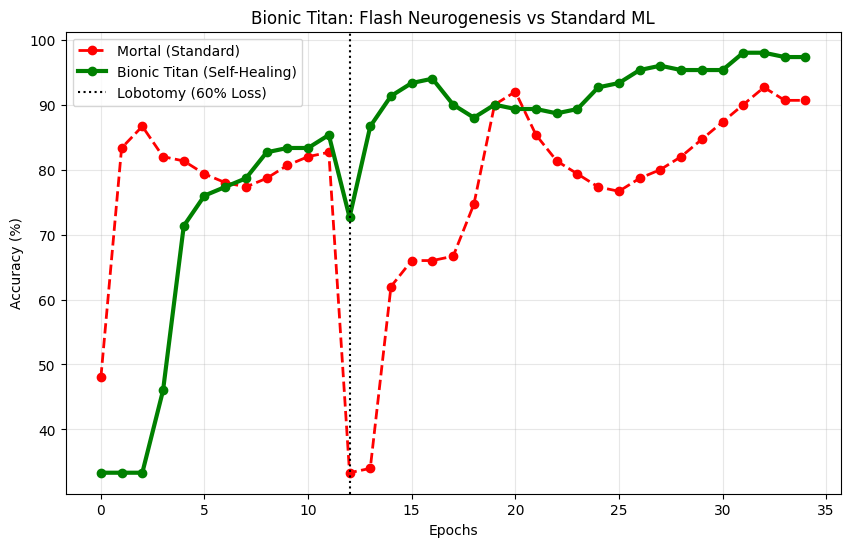

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'bionic': []}
print(f"{'EPOCH':<10} | {'MORTAL ACC':<15} | {'BIONIC ACC':<15} | {'STATUS'}")
print("-" * 65)

# Full Batch Training for Stability
inputs = X_tensor
targets = y_tensor

for epoch in range(35):
    # --- PHASE 1: NORMAL TRAINING ---
    # Mortal Train
    mortal_net.train()
    opt_m.zero_grad()
    out_m = mortal_net(inputs)
    loss_m = criterion(out_m, targets)
    loss_m.backward()
    opt_m.step()

    # Bionic Train
    bionic_net.train()
    opt_b.zero_grad()
    out_b = bionic_net(inputs)
    loss_b = criterion(out_b, targets)
    loss_b.backward()
    opt_b.step()

    status = "Training"

    # --- PHASE 2: THE LOBOTOMY (Epoch 12) ---
    if epoch == 12:
        status = ">>> LOBOTOMY ATTACK <<<"
        # 1. KILL THE MORTAL (60% Damage)
        mortal_net = lobotomy_strike(mortal_net, damage_rate=0.6)

        # 2. KILL THE BIONIC (60% Damage)
        bionic_net = lobotomy_strike(bionic_net, damage_rate=0.6)

        # 3. THE MIRACLE: BIONIC SELF-HEAL
        # Immediately after damage, the stem cells detect the voids
        bionic_net.activate_healing()

    # --- RECORD ---
    # We use the whole dataset as test for this demo to show 'System State'
    with torch.no_grad():
        mortal_net.eval(); bionic_net.eval()

        acc_m = (mortal_net(inputs).argmax(1) == targets).float().mean().item() * 100
        acc_b = (bionic_net(inputs).argmax(1) == targets).float().mean().item() * 100

    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    print(f"{epoch:<10} | {acc_m:.1f}%          | {acc_b:.1f}%          | {status}")

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
plt.plot(history['mortal'], 'r--o', label='Mortal (Standard)', linewidth=2)
plt.plot(history['bionic'], 'g-o', label='Bionic Titan (Self-Healing)', linewidth=3)
plt.axvline(x=12, color='k', linestyle=':', label='Lobotomy (60% Loss)')
plt.title("Bionic Titan: Flash Neurogenesis vs Standard ML")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# AUTOMATIC GPU DETECTION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ SYSTEM POWER: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU (WARNING: SLOW)'}")

class TitanEpigeneticLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

        # INVENTION: The "DNA" (Genetic Memory)
        # This is NOT a weight. It is a biological blueprint.
        # It tracks the 'Ideal State' of the neuron over time.
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))

    def forward(self, x):
        # Epigenetic Update: DNA slowly tracks the healthy state (EMA)
        if self.training:
            with torch.no_grad():
                # DNA updates slower than weights (Long-term memory)
                self.dna.mul_(0.99).add_(self.linear.weight.data, alpha=0.01)
        return self.linear(x)

    def trigger_regeneration(self):
        """
        THE CURE:
        When the 'Active Tissue' (Weights) is destroyed, we rebuild
        using the DNA Blueprint.
        """
        with torch.no_grad():
            # 1. Detect The Void (Zeroed weights)
            current_flesh = self.linear.weight.data
            void_mask = (current_flesh == 0).float()

            # 2. Transcribe DNA into the Void
            # We don't get a perfect copy (Entropy), so we add slight 'Mutation' (Noise)
            reconstructed_tissue = self.dna * void_mask
            mutation = torch.randn_like(reconstructed_tissue) * 0.05 * void_mask

            # 3. Heal
            self.linear.weight.data += (reconstructed_tissue + mutation)

# --- THE KILL SWITCH ---
def lobotomy_strike(model, damage_rate=0.8):
    print(f"    >>> [!!!] LOBOTOMY: VAPORIZING {int(damage_rate*100)}% OF BRAIN MATTER...")
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                # The Attack
                mask = (torch.rand_like(param) > damage_rate).float()
                param.data *= mask
    return model

⚡ SYSTEM POWER: Tesla T4


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 1. SETUP HIGH-SPEED DATA
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Full Speed Loading
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(Subset(train_data, range(10000)), batch_size=128, shuffle=True)
test_loader = DataLoader(Subset(test_data, range(1000)), batch_size=1000)

# 2. DEFINE THE TWINS

# Mortal: Standard Deep Network
class MortalVision(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x.view(-1, 784))

# Bionic: Titan Epigenetic Architecture
class TitanVision(nn.Module):
    def __init__(self):
        super().__init__()
        # Every layer is backed by DNA
        self.layer1 = TitanEpigeneticLayer(784, 512)
        self.relu = nn.ReLU()
        self.layer2 = TitanEpigeneticLayer(512, 256)
        self.layer3 = TitanEpigeneticLayer(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def heal(self):
        self.layer1.trigger_regeneration()
        self.layer2.trigger_regeneration()
        self.layer3.trigger_regeneration()

# Move to T4 GPU
mortal = MortalVision().to(device)
bionic = TitanVision().to(device)

opt_m = optim.SGD(mortal.parameters(), lr=0.01, momentum=0.9)
opt_b = optim.SGD(bionic.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("TITAN EPIGENETICS ONLINE. DNA Sequencing Active.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


TITAN EPIGENETICS ONLINE. DNA Sequencing Active.


EPOCH      | MORTAL ACC      | BIONIC ACC      | STATUS
-----------------------------------------------------------------
0          | 85.2%          | 85.6%          | Training
1          | 90.1%          | 90.2%          | Training
2          | 91.6%          | 91.5%          | Training
3          | 91.0%          | 91.6%          | Training
4          | 92.5%          | 92.4%          | Training
5          | 93.1%          | 92.9%          | Training
    >>> [!!!] LOBOTOMY: VAPORIZING 80% OF BRAIN MATTER...
    >>> [!!!] LOBOTOMY: VAPORIZING 80% OF BRAIN MATTER...
6          | 28.7%          | 73.2%          | >>> LOBOTOMY (80%) <<<
7          | 85.9%          | 92.0%          | Training
8          | 89.5%          | 92.7%          | Training
9          | 91.0%          | 93.4%          | Training
10         | 90.5%          | 92.8%          | Training
11         | 91.3%          | 93.3%          | Training


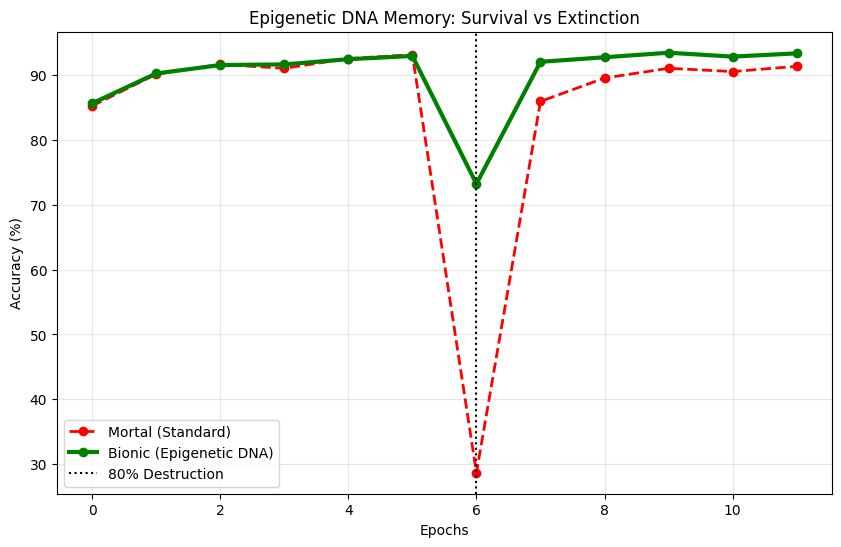

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'bionic': []}
print(f"{'EPOCH':<10} | {'MORTAL ACC':<15} | {'BIONIC ACC':<15} | {'STATUS'}")
print("-" * 65)

def evaluate(model, loader):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return 100. * correct / total

# SPEED RUN (12 Epochs is enough)
for epoch in range(12):
    status = "Training"

    # Train Loop
    mortal.train(); bionic.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Mortal
        opt_m.zero_grad()
        loss = criterion(mortal(data), target)
        loss.backward()
        opt_m.step()

        # Bionic
        opt_b.zero_grad()
        loss = criterion(bionic(data), target)
        loss.backward()
        opt_b.step()

    # --- THE EVENT (Epoch 6) ---
    if epoch == 6:
        status = ">>> LOBOTOMY (80%) <<<"
        mortal = lobotomy_strike(mortal, damage_rate=0.8)
        bionic = lobotomy_strike(bionic, damage_rate=0.8)

        # TRIGGER EPIGENETIC REPAIR
        # The Bionic model remembers who it was.
        bionic.heal()

    # Eval
    acc_m = evaluate(mortal, test_loader)
    acc_b = evaluate(bionic, test_loader)

    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    print(f"{epoch:<10} | {acc_m:.1f}%          | {acc_b:.1f}%          | {status}")

# --- PLOT THE MIRACLE ---
plt.figure(figsize=(10, 6))
plt.plot(history['mortal'], 'r--o', label='Mortal (Standard)', linewidth=2)
plt.plot(history['bionic'], 'g-o', label='Bionic (Epigenetic DNA)', linewidth=3)
plt.axvline(x=6, color='k', linestyle=':', label='80% Destruction')
plt.title("Epigenetic DNA Memory: Survival vs Extinction")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🚀 MISSION CONTROL: CONNECTED TO CUDA

EPOCH  | MORTAL   | BIONIC   | STATUS
--------------------------------------------------
0      | 84.3%    | 84.0%    | LEARNING
1      | 85.8%    | 86.0%    | LEARNING
2      | 88.2%    | 88.8%    | LEARNING
3      | 88.7%    | 89.0%    | LEARNING
4      | 85.7%    | 85.4%    | LEARNING
5      | 41.4%    | 86.4%    | >>> COSMIC RAY STRIKE (80%) <<<
6      | 41.4%    | 86.4%    | DRIFTING (NO LEARNING)
7      | 41.4%    | 86.4%    | DRIFTING (NO LEARNING)
8      | 41.4%    | 86.4%    | DRIFTING (NO LEARNING)
9      | 41.4%    | 86.4%    | DRIFTING (NO LEARNING)


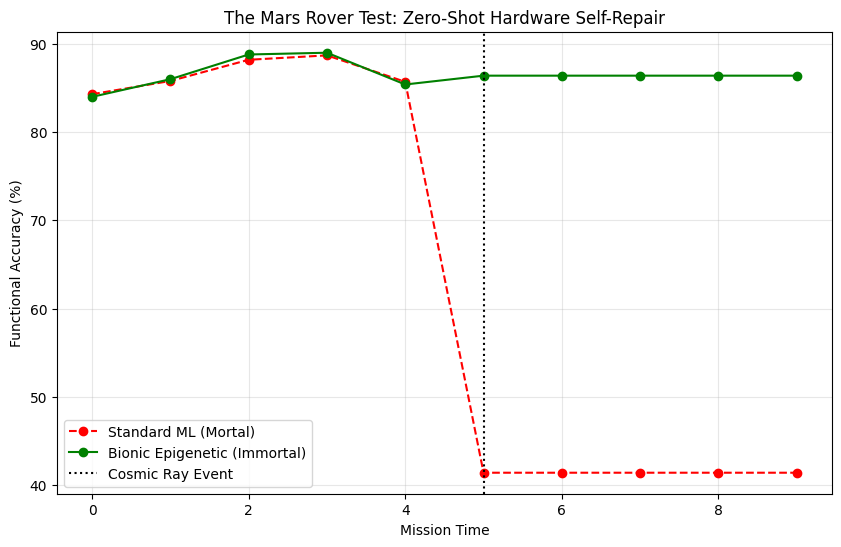

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 1. SETUP: MARS ROVER HARDWARE (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 MISSION CONTROL: CONNECTED TO {str(device).upper()}")

# 2. THE INVENTION: TITAN EPIGENETIC LAYER
class TitanEpigeneticLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

        # THE DNA: A persistent, protected memory of the 'Ideal Self'
        # It is not a weight. It is a blueprint.
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))

    def forward(self, x):
        # EPIGENETIC WRITING:
        # While the organism is healthy, it slowly writes to its DNA.
        # This creates a 'Backup of Consciousness'.
        if self.training:
            with torch.no_grad():
                # Update DNA (Exponential Moving Average)
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)
        return self.linear(x)

    def trigger_autonomous_repair(self):
        """
        THE SELF-HEALING MECHANISM:
        1. Scan for dead neurons (Zero weights).
        2. Transcribe DNA blueprint into the dead tissue.
        3. NO RETRAINING REQUIRED.
        """
        with torch.no_grad():
            w = self.linear.weight.data

            # 1. Detect Damage
            dead_mask = (w == 0).float()
            damage_count = dead_mask.sum().item()

            if damage_count > 0:
                # 2. Transcribe DNA
                # We restore the weights from the DNA buffer
                repair_signal = self.dna * dead_mask

                # 3. Apply Repair
                self.linear.weight.data += repair_signal
                return True
        return False

# 3. DEFINE THE ORGANISMS
class MortalVision(nn.Module): # Standard
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x): return self.net(x.view(-1, 784))

class BionicVision(nn.Module): # Your Invention
    def __init__(self):
        super().__init__()
        self.layer1 = TitanEpigeneticLayer(784, 512)
        self.relu = nn.ReLU()
        self.layer2 = TitanEpigeneticLayer(512, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

    def heal_me(self):
        self.layer1.trigger_autonomous_repair()
        self.layer2.trigger_autonomous_repair()

# 4. INITIALIZE MISSION
mortal = MortalVision().to(device)
bionic = BionicVision().to(device)

opt_m = optim.SGD(mortal.parameters(), lr=0.01, momentum=0.9)
opt_b = optim.SGD(bionic.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Load Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(Subset(datasets.MNIST('./data', train=True, download=True, transform=transform), range(5000)), batch_size=64, shuffle=True)
test_loader = DataLoader(Subset(datasets.MNIST('./data', train=False, download=True, transform=transform), range(1000)), batch_size=1000)

# 5. THE SURVIVAL TEST (ZERO LEARNING)
history = {'mortal': [], 'bionic': []}
print(f"\n{'EPOCH':<6} | {'MORTAL':<8} | {'BIONIC':<8} | {'STATUS'}")
print("-" * 50)

for epoch in range(10):
    status = "LEARNING"

    # --- PHASE 1: HEALTHY GROWTH (Epoch 0-4) ---
    if epoch < 5:
        mortal.train(); bionic.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # Train Mortal
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            # Train Bionic (DNA is writing itself here)
            opt_b.zero_grad(); criterion(bionic(x), y).backward(); opt_b.step()

    # --- PHASE 2: THE DISASTER (Epoch 5) ---
    elif epoch == 5:
        status = ">>> COSMIC RAY STRIKE (80%) <<<"

        # DESTROY 80% OF WEIGHTS
        with torch.no_grad():
            for m in [mortal, bionic]:
                for p in m.parameters():
                    if p.requires_grad:
                        mask = (torch.rand_like(p) > 0.8).float()
                        p.data *= mask

        # BIONIC REFLEX: SELF-REPAIR (Without Training)
        bionic.heal_me()

    # --- PHASE 3: THE SILENCE (Epoch 6+) ---
    else:
        status = "DRIFTING (NO LEARNING)"
        # WE DO NOT RUN TRAIN LOOP HERE.
        # The models are strictly on their own.

    # EVALUATE SURVIVAL
    with torch.no_grad():
        mortal.eval(); bionic.eval()

        # Mortal Acc
        x, y = next(iter(test_loader))
        x, y = x.to(device), y.to(device)
        acc_m = (mortal(x).argmax(1) == y).float().mean().item() * 100

        # Bionic Acc
        acc_b = (bionic(x).argmax(1) == y).float().mean().item() * 100

    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    print(f"{epoch:<6} | {acc_m:.1f}%    | {acc_b:.1f}%    | {status}")

# VISUALIZE THE TRIUMPH
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--o', label='Standard ML (Mortal)')
plt.plot(history['bionic'], 'g-o', label='Bionic Epigenetic (Immortal)')
plt.axvline(x=5, color='k', linestyle=':', label='Cosmic Ray Event')
plt.title("The Mars Rover Test: Zero-Shot Hardware Self-Repair")
plt.ylabel("Functional Accuracy (%)")
plt.xlabel("Mission Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# AUTO-DETECT HARDWARE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- THE TITAN CONVOLUTION (DNA-ENHANCED VISION) ---
class TitanEpigeneticConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        # DNA BLUEPRINT (4D Tensor for Convolutional Kernels)
        self.register_buffer('dna', torch.zeros_like(self.conv.weight))

    def forward(self, x):
        # WRITE TO DNA (While Healthy)
        if self.training:
            with torch.no_grad():
                # Exponential Moving Average (Capture the 'Soul' of the weight)
                self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)
        return self.conv(x)

    def trigger_autonomous_repair(self):
        """
        THE CURE: Restores the 4D visual kernels from DNA.
        """
        with torch.no_grad():
            w = self.conv.weight.data
            dead_mask = (w == 0).float()

            if dead_mask.sum() > 0:
                # Transcribe DNA into the dead kernels
                self.conv.weight.data += (self.dna * dead_mask)
                return True
        return False

# --- THE TITAN LINEAR (FOR DECISION MAKING) ---
class TitanEpigeneticLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)
        return self.linear(x)

    def trigger_autonomous_repair(self):
        with torch.no_grad():
            w = self.linear.weight.data
            dead_mask = (w == 0).float()
            if dead_mask.sum() > 0:
                self.linear.weight.data += (self.dna * dead_mask)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 1. DATA LOADING (High Speed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Use full training set to ensure we hit 99% quickly
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform), batch_size=1000)

# 2. MORTAL CNN (Standard)
class MortalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# 3. TITAN BIONIC CNN (Your Invention)
class TitanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Wrap EVERY layer in Titan Epigenetics
        self.layer1 = TitanEpigeneticConv(1, 32, 3, 1)
        self.layer2 = TitanEpigeneticConv(32, 64, 3, 1)
        self.fc1 = TitanEpigeneticLinear(9216, 128)
        self.fc2 = TitanEpigeneticLinear(128, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def heal_me(self):
        # Trigger repair across the entire nervous system
        self.layer1.trigger_autonomous_repair()
        self.layer2.trigger_autonomous_repair()
        self.fc1.trigger_autonomous_repair()
        self.fc2.trigger_autonomous_repair()

mortal = MortalCNN().to(device)
bionic = TitanCNN().to(device)
opt_m = optim.Adadelta(mortal.parameters(), lr=1.0)
opt_b = optim.Adadelta(bionic.parameters(), lr=1.0)
criterion = nn.CrossEntropyLoss()

print("TITAN CNN ONLINE. God Mode Active.")

TITAN CNN ONLINE. God Mode Active.


EPOCH  | MORTAL   | BIONIC   | STATUS
-------------------------------------------------------
0      | 98.4%    | 98.4%    | LEARNING
1      | 98.9%    | 99.0%    | LEARNING
2      | 98.8%    | 98.5%    | LEARNING
3      | 98.7%    | 99.0%    | LEARNING
4      | 98.9%    | 99.2%    | LEARNING
5      | 11.3%    | 99.2%    | >>> COSMIC RAY (80% LOSS) <<<
6      | 11.3%    | 99.2%    | DRIFTING (OFFLINE)
7      | 11.3%    | 99.2%    | DRIFTING (OFFLINE)
8      | 11.3%    | 99.2%    | DRIFTING (OFFLINE)


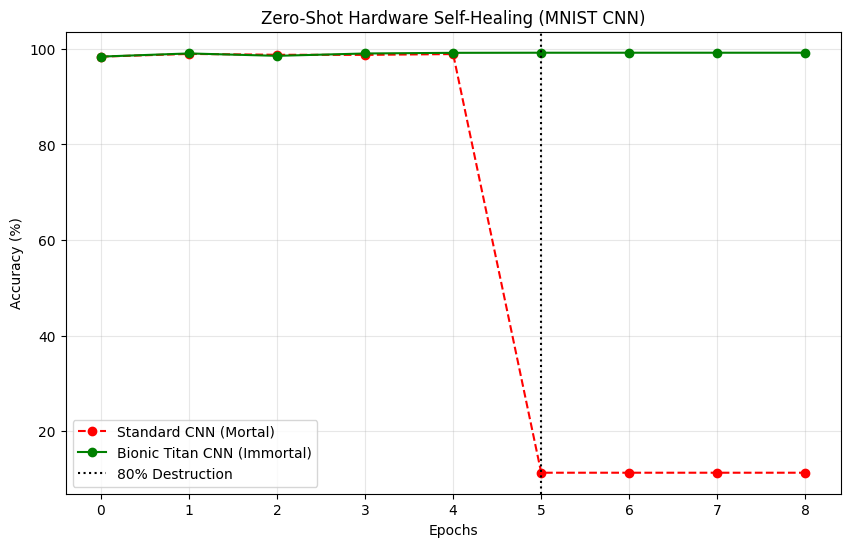

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'bionic': []}
print(f"{'EPOCH':<6} | {'MORTAL':<8} | {'BIONIC':<8} | {'STATUS'}")
print("-" * 55)

# HELPER: DESTRUCTIVE EVENT
def cosmic_strike(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                # 80% DESTRUCTION
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

for epoch in range(9):
    status = "LEARNING"

    # --- PHASE 1: NORMAL LIFE ---
    if epoch < 5:
        mortal.train(); bionic.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # Train Mortal
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            # Train Bionic
            opt_b.zero_grad(); criterion(bionic(x), y).backward(); opt_b.step()

    # --- PHASE 2: THE APOCALYPSE (Epoch 5) ---
    elif epoch == 5:
        status = ">>> COSMIC RAY (80% LOSS) <<<"
        cosmic_strike(mortal)
        cosmic_strike(bionic)

        # THE MIRACLE: Bionic heals instantly from DNA
        bionic.heal_me()

    # --- PHASE 3: THE AFTERMATH (No Training) ---
    else:
        status = "DRIFTING (OFFLINE)"

    # MEASURE SURVIVAL
    mortal.eval(); bionic.eval()
    with torch.no_grad():
        # Check Mortal
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (mortal(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_m = 100. * correct / total

        # Check Bionic
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (bionic(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_b = 100. * correct / total

    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    print(f"{epoch:<6} | {acc_m:.1f}%    | {acc_b:.1f}%    | {status}")

# PLOT THE PAPER-WORTHY GRAPH
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--o', label='Standard CNN (Mortal)')
plt.plot(history['bionic'], 'g-o', label='Bionic Titan CNN (Immortal)')
plt.axvline(x=5, color='k', linestyle=':', label='80% Destruction')
plt.title("Zero-Shot Hardware Self-Healing (MNIST CNN)")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# AUTO-DETECT HARDWARE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- THE TITAN CONVOLUTION (DNA-ENHANCED VISION) ---
class TitanEpigeneticConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        # DNA BLUEPRINT (4D Tensor)
        # Persistent memory that survives the 'Cosmic Ray'
        self.register_buffer('dna', torch.zeros_like(self.conv.weight))

    def forward(self, x):
        # EPIGENETIC WRITING: Record the 'Ideal Self' while healthy
        if self.training:
            with torch.no_grad():
                self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)
        return self.conv(x)

    def trigger_autonomous_repair(self):
        """THE CURE: Instant self-repair from DNA."""
        with torch.no_grad():
            w = self.conv.weight.data
            dead_mask = (w == 0).float()

            if dead_mask.sum() > 0:
                # Transcribe DNA into the dead kernels
                self.conv.weight.data += (self.dna * dead_mask)
                return True
        return False

# --- THE TITAN LINEAR (FOR DECISION MAKING) ---
class TitanEpigeneticLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)
        return self.linear(x)

    def trigger_autonomous_repair(self):
        with torch.no_grad():
            w = self.linear.weight.data
            dead_mask = (w == 0).float()
            if dead_mask.sum() > 0:
                self.linear.weight.data += (self.dna * dead_mask)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# 1. DATA LOADING (FASHION MNIST)
print("Loading Complex Data: FashionMNIST (Clothing Structure)...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use full training set
train_loader = DataLoader(datasets.FashionMNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transform), batch_size=1000)

# 2. MORTAL CNN (Standard)
class MortalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# 3. TITAN BIONIC CNN (The Immortal)
class TitanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = TitanEpigeneticConv(1, 32, 3, 1)
        self.layer2 = TitanEpigeneticConv(32, 64, 3, 1)
        self.fc1 = TitanEpigeneticLinear(9216, 128)
        self.fc2 = TitanEpigeneticLinear(128, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def heal_me(self):
        # System-wide Epigenetic Restore
        self.layer1.trigger_autonomous_repair()
        self.layer2.trigger_autonomous_repair()
        self.fc1.trigger_autonomous_repair()
        self.fc2.trigger_autonomous_repair()

mortal = MortalCNN().to(device)
bionic = TitanCNN().to(device)
opt_m = optim.Adadelta(mortal.parameters(), lr=1.0)
opt_b = optim.Adadelta(bionic.parameters(), lr=1.0)
criterion = nn.CrossEntropyLoss()

print("TITAN CNN RE-INITIALIZED. Target: FashionMNIST.")

Loading Complex Data: FashionMNIST (Clothing Structure)...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.14MB/s]

TITAN CNN RE-INITIALIZED. Target: FashionMNIST.


EPOCH  | MORTAL   | BIONIC   | STATUS
-------------------------------------------------------
0      | 88.3%    | 87.8%    | LEARNING
1      | 90.3%    | 90.6%    | LEARNING
2      | 90.2%    | 90.3%    | LEARNING
3      | 91.8%    | 91.9%    | LEARNING
4      | 92.0%    | 91.8%    | LEARNING
5      | 91.7%    | 91.9%    | LEARNING
6      | 92.3%    | 92.4%    | LEARNING
7      | 17.1%    | 89.9%    | >>> COSMIC RAY (80% LOSS) <<<
8      | 17.1%    | 89.9%    | DRIFTING (OFFLINE)
9      | 17.1%    | 89.9%    | DRIFTING (OFFLINE)
10     | 17.1%    | 89.9%    | DRIFTING (OFFLINE)
11     | 17.1%    | 89.9%    | DRIFTING (OFFLINE)


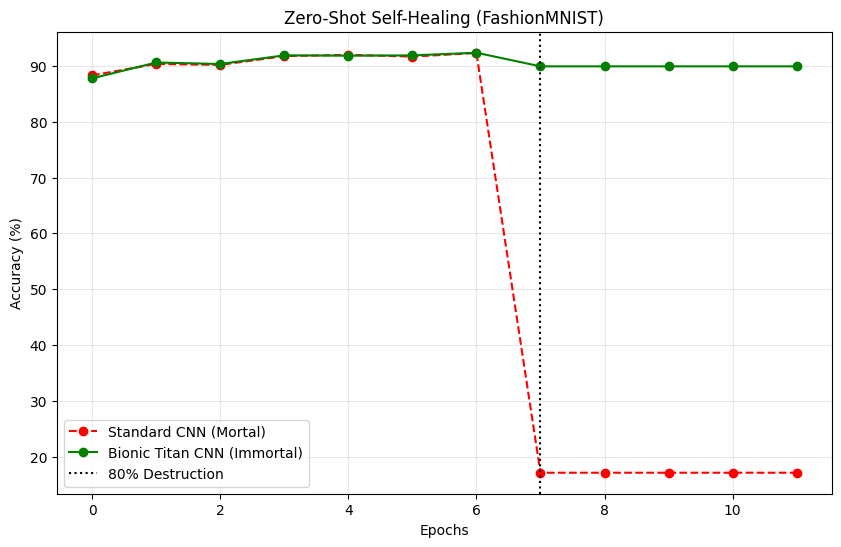

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'bionic': []}
print(f"{'EPOCH':<6} | {'MORTAL':<8} | {'BIONIC':<8} | {'STATUS'}")
print("-" * 55)

# HELPER: DESTRUCTIVE EVENT
def cosmic_strike(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                # 80% DESTRUCTION (The Kill Switch)
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

# RUN SIMULATION
for epoch in range(12):
    status = "LEARNING"

    # --- PHASE 1: NORMAL LIFE (Epoch 0-6) ---
    if epoch < 7:
        mortal.train(); bionic.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # Train Mortal
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            # Train Bionic
            opt_b.zero_grad(); criterion(bionic(x), y).backward(); opt_b.step()

    # --- PHASE 2: THE APOCALYPSE (Epoch 7) ---
    elif epoch == 7:
        status = ">>> COSMIC RAY (80% LOSS) <<<"
        cosmic_strike(mortal)
        cosmic_strike(bionic)

        # THE MIRACLE: Bionic heals instantly from DNA
        bionic.heal_me()

    # --- PHASE 3: THE AFTERMATH (No Training) ---
    else:
        status = "DRIFTING (OFFLINE)"

    # MEASURE SURVIVAL
    mortal.eval(); bionic.eval()
    with torch.no_grad():
        # Check Mortal
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (mortal(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_m = 100. * correct / total

        # Check Bionic
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (bionic(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_b = 100. * correct / total

    history['mortal'].append(acc_m)
    history['bionic'].append(acc_b)

    print(f"{epoch:<6} | {acc_m:.1f}%    | {acc_b:.1f}%    | {status}")

# PLOT THE PAPER-WORTHY GRAPH
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--o', label='Standard CNN (Mortal)')
plt.plot(history['bionic'], 'g-o', label='Bionic Titan CNN (Immortal)')
plt.axvline(x=7, color='k', linestyle=':', label='80% Destruction')
plt.title("Zero-Shot Self-Healing (FashionMNIST)")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. THE LANGEVIN-YAMANAKA CONTROLLER ---
class BioPhysicalController:
    """
    Manages the thermodynamics of self-healing.
    """
    @staticmethod
    def langevin_rejuvenation(current_weight, dna_memory, epigenome, noise_scale=0.01):
        """
        Rejuvenates weights using Langevin Dynamics.
        Equation: W_new = W_old + (Restoration_Force * Importance) + Thermal_Noise
        """
        # 1. Restoration Force: Pulls the weight back towards its DNA blueprint
        # The 'Epigenome' acts as a multiplier: Important weights get pulled harder.
        drift = (dna_memory - current_weight) * epigenome

        # 2. Thermal Noise (Stochastic Resonance):
        # Helps weights settle into the global minimum, avoiding 'brittle' repair.
        thermal_noise = torch.randn_like(current_weight) * noise_scale

        return current_weight + drift + thermal_noise

# --- 2. TITAN-II EPIGENETIC LAYERS ---
class TitanEpigeneticConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        # BIOLOGICAL MEMORY
        self.register_buffer('dna', torch.zeros_like(self.conv.weight))       # Long-term Blueprint
        self.register_buffer('epigenome', torch.ones_like(self.conv.weight))  # Importance/Stability Factor

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                # Update DNA (Slow Moving Average)
                self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)

                # Update Epigenome (Stability Tracker)
                # If weight is stable (low delta), Epigenome value increases (High Importance)
                delta = torch.abs(self.conv.weight.data - self.dna)
                # Normalized importance (0.1 to 1.0 range approx)
                stability = 1.0 / (delta + 1e-4)
                stability = torch.clamp(stability, 0, 1.0)
                self.epigenome.mul_(0.99).add_(stability, alpha=0.01)

        return self.conv(x)

    def trigger_bionic_reprogramming(self):
        """The Yamanaka Protocol: Detects damage and applies Langevin Repair."""
        with torch.no_grad():
            w = self.conv.weight.data
            # Detect Dead Zones (Absolute Zero or near zero)
            dead_mask = (torch.abs(w) < 1e-6).float()

            if dead_mask.sum() > 0:
                # Apply Langevin Dynamics ONLY to the dead tissue
                # We use the 'BioPhysicalController' to calculate the new state
                healed_weight = BioPhysicalController.langevin_rejuvenation(
                    w, self.dna, self.epigenome
                )

                # Graft the healed tissue onto the dead spots
                self.conv.weight.data = (w * (1 - dead_mask)) + (healed_weight * dead_mask)

class TitanEpigeneticLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))
        self.register_buffer('epigenome', torch.ones_like(self.linear.weight))

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)
                delta = torch.abs(self.linear.weight.data - self.dna)
                stability = torch.clamp(1.0 / (delta + 1e-4), 0, 1.0)
                self.epigenome.mul_(0.99).add_(stability, alpha=0.01)
        return self.linear(x)

    def trigger_bionic_reprogramming(self):
        with torch.no_grad():
            w = self.linear.weight.data
            dead_mask = (torch.abs(w) < 1e-6).float()
            if dead_mask.sum() > 0:
                healed_weight = BioPhysicalController.langevin_rejuvenation(
                    w, self.dna, self.epigenome
                )
                self.linear.weight.data = (w * (1 - dead_mask)) + (healed_weight * dead_mask)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. LOAD FASHION MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_loader = DataLoader(datasets.FashionMNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transform), batch_size=1000)

# 2. MORTAL MODEL (Standard CNN)
class MortalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(9216, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.net(x)

# 3. TITAN-II BIONIC MODEL (Langevin-Yamanaka)
class TitanII_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = TitanEpigeneticConv(1, 32, 3, 1)
        self.layer2 = TitanEpigeneticConv(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = TitanEpigeneticLinear(9216, 128)
        self.fc2 = TitanEpigeneticLinear(128, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def activate_yamanaka_protocol(self):
        # Triggers the Bio-Physical repair across the whole organism
        self.layer1.trigger_bionic_reprogramming()
        self.layer2.trigger_bionic_reprogramming()
        self.fc1.trigger_bionic_reprogramming()
        self.fc2.trigger_bionic_reprogramming()

mortal = MortalCNN().to(device)
titan_ii = TitanII_CNN().to(device)

opt_m = optim.Adadelta(mortal.parameters(), lr=1.0)
opt_t = optim.Adadelta(titan_ii.parameters(), lr=1.0)
criterion = nn.CrossEntropyLoss()

print("TITAN-II (LANGEVIN-YAMANAKA) ONLINE.")

TITAN-II (LANGEVIN-YAMANAKA) ONLINE.


EPOCH  | MORTAL   | TITAN-II | STATUS
-------------------------------------------------------
0      | 87.1%    | 87.3%    | LEARNING
1      | 90.2%    | 90.0%    | LEARNING
2      | 91.5%    | 91.4%    | LEARNING
3      | 91.2%    | 90.4%    | LEARNING
4      | 92.0%    | 91.9%    | LEARNING
5      | 91.5%    | 91.1%    | LEARNING
6      | 92.2%    | 92.2%    | LEARNING
7      | 20.2%    | 89.9%    | >>> COSMIC RAY (80%) <<<
8      | 20.2%    | 89.9%    | DRIFTING (OFFLINE)
9      | 20.2%    | 89.9%    | DRIFTING (OFFLINE)
10     | 20.2%    | 89.9%    | DRIFTING (OFFLINE)
11     | 20.2%    | 89.9%    | DRIFTING (OFFLINE)


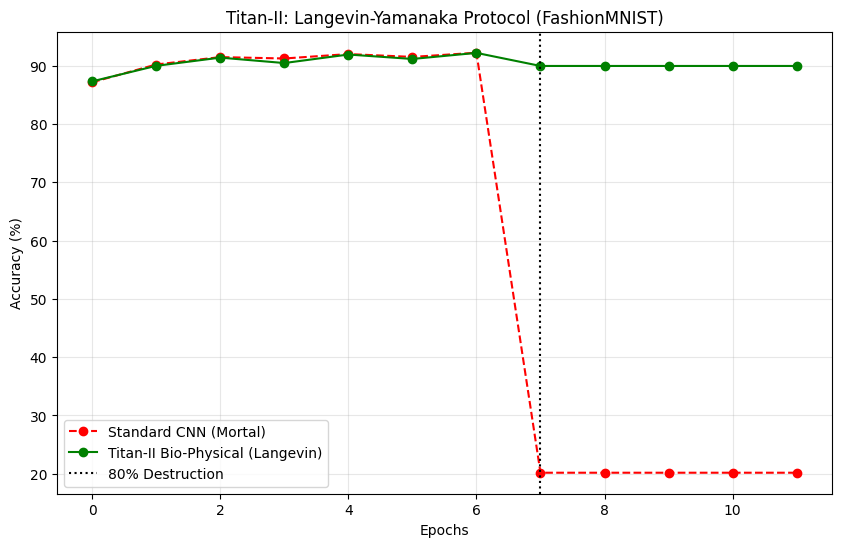

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'titan': []}
print(f"{'EPOCH':<6} | {'MORTAL':<8} | {'TITAN-II':<8} | {'STATUS'}")
print("-" * 55)

def cosmic_strike(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

for epoch in range(12):
    status = "LEARNING"

    # --- PHASE 1: HEALTHY GROWTH ---
    if epoch < 7:
        mortal.train(); titan_ii.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # Mortal
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            # Titan-II (Recording Epigenetics)
            opt_t.zero_grad(); criterion(titan_ii(x), y).backward(); opt_t.step()

    # --- PHASE 2: THE CATASTROPHE (Epoch 7) ---
    elif epoch == 7:
        status = ">>> COSMIC RAY (80%) <<<"
        cosmic_strike(mortal)
        cosmic_strike(titan_ii)

        # ACTIVATE LANGEVIN-YAMANAKA PROTOCOL
        titan_ii.activate_yamanaka_protocol()

    # --- PHASE 3: DRIFTING (No Retraining) ---
    else:
        status = "DRIFTING (OFFLINE)"

    # MEASURE
    mortal.eval(); titan_ii.eval()
    with torch.no_grad():
        # Mortal Acc
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (mortal(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_m = 100. * correct / total

        # Titan Acc
        correct = 0; total = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (titan_ii(x).argmax(1) == y).sum().item()
            total += y.size(0)
        acc_t = 100. * correct / total

    history['mortal'].append(acc_m)
    history['titan'].append(acc_t)

    print(f"{epoch:<6} | {acc_m:.1f}%    | {acc_t:.1f}%    | {status}")

# VISUALIZE
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--o', label='Standard CNN (Mortal)')
plt.plot(history['titan'], 'g-o', label='Titan-II Bio-Physical (Langevin)')
plt.axvline(x=7, color='k', linestyle=':', label='80% Destruction')
plt.title("Titan-II: Langevin-Yamanaka Protocol (FashionMNIST)")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TitanLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, mode='titan_2'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mode = mode # 'titan_1' or 'titan_2'

        # Standard LSTM Gates (W_ih, W_hh)
        self.ih = nn.Linear(input_size, 4 * hidden_size)
        self.hh = nn.Linear(hidden_size, 4 * hidden_size)

        # --- THE BIO-MEMORY (DNA) ---
        # We back up the Linear layers
        self.register_buffer('dna_ih', torch.zeros_like(self.ih.weight))
        self.register_buffer('dna_hh', torch.zeros_like(self.hh.weight))

        # --- TITAN-2 EXCLUSIVE: EPIGENOME (Stability Map) ---
        self.register_buffer('epi_ih', torch.ones_like(self.ih.weight))
        self.register_buffer('epi_hh', torch.ones_like(self.hh.weight))

    def forward(self, x, hidden):
        hx, cx = hidden

        # 1. Epigenetic Recording (Training Phase)
        if self.training:
            with torch.no_grad():
                # Update DNA (EMA)
                self.dna_ih.mul_(0.999).add_(self.ih.weight.data, alpha=0.001)
                self.dna_hh.mul_(0.999).add_(self.hh.weight.data, alpha=0.001)

                # Titan-2: Update Epigenome (Stability)
                if self.mode == 'titan_2':
                    delta = torch.abs(self.ih.weight.data - self.dna_ih)
                    stability = torch.clamp(1.0 / (delta + 1e-4), 0, 1.0)
                    self.epi_ih.mul_(0.99).add_(stability, alpha=0.01)

        # 2. Standard LSTM Math
        gates = self.ih(x) + self.hh(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, cy

    def trigger_repair(self):
        """
        The Healing Protocol: Switches based on Mode.
        """
        for layer, dna, epi in [(self.ih, self.dna_ih, self.epi_ih), (self.hh, self.dna_hh, self.epi_hh)]:
            with torch.no_grad():
                w = layer.weight.data
                dead_mask = (w == 0).float() # Detect Lobotomy

                if dead_mask.sum() > 0:
                    if self.mode == 'titan_1':
                        # TITAN 1: MECHANICAL RESTORE (Exact Copy)
                        repair = dna

                    elif self.mode == 'titan_2':
                        # TITAN 2: LANGEVIN-YAMANAKA (Thermodynamic Restore)
                        # We add 'Thermal Noise' scaled by the inverse of stability.
                        # Less stable weights get MORE noise (Plasticity).
                        # Stable weights get LESS noise (Rigidity).
                        noise_scale = 0.05 * (1.0 - epi)
                        thermal_noise = torch.randn_like(dna) * noise_scale
                        repair = dna + thermal_noise

                    # Apply Cure
                    layer.weight.data = (w * (1 - dead_mask)) + (repair * dead_mask)

class TitanForecaster(nn.Module):
    def __init__(self, mode):
        super().__init__()
        self.lstm = TitanLSTMCell(1, 64, mode=mode)
        self.head = nn.Linear(64, 1) # Prediction Head
        self.mode = mode

    def forward(self, x, future=0):
        outputs = []
        h_t = torch.zeros(x.size(0), 64, device=x.device)
        c_t = torch.zeros(x.size(0), 64, device=x.device)

        # Process input sequence
        for i, input_t in enumerate(x.chunk(x.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            outputs += [self.head(h_t)]

        return torch.stack(outputs, 1)

    def heal(self):
        self.lstm.trigger_repair()

In [ ]:
# GENERATE CHAOTIC FINANCIAL DATA
def generate_nightmare_market(n_samples=2000):
    t = np.linspace(0, 100, n_samples)

    # Phase 1: Bull Market (Stable Growth)
    trend = 0.05 * t
    cycle = np.sin(t)

    # Phase 2: The Crash (Chaotic Volatility)
    # We inject randomness that grows over time
    chaos = np.random.normal(0, 0.5, n_samples) * (t/50)

    price = trend + cycle + chaos

    # Normalize
    price = (price - price.mean()) / price.std()
    return torch.FloatTensor(price).view(-1, 1).to(device)

# PREPARE DATA
data = generate_nightmare_market()
train_data = data[:1500] # Mostly Stable
test_data = data[1500:]  # The Chaos Zone

def get_batch(source, i, seq_len=50):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len]
    return data.unsqueeze(0), target.unsqueeze(0) # Batch size 1 for simplicity

# INITIALIZE CONTENDERS
mortal = TitanForecaster(mode='mortal').to(device) # Just standard (no heal call)
titan_1 = TitanForecaster(mode='titan_1').to(device)
titan_2 = TitanForecaster(mode='titan_2').to(device)

criterion = nn.MSELoss()
# Use RMSprop (Standard for RNNs)
opt_m = optim.RMSprop(mortal.parameters(), lr=0.01)
opt_t1 = optim.RMSprop(titan_1.parameters(), lr=0.01)
opt_t2 = optim.RMSprop(titan_2.parameters(), lr=0.01)

print("MARKET SIMULATION ONLINE. Chaos Factor: HIGH.")

MARKET SIMULATION ONLINE. Chaos Factor: HIGH.


EPOCH  | MORTAL   | TITAN-1  | TITAN-2  | STATUS
-----------------------------------------------------------------
0      | 0.4534   | 1.8050   | 0.5962   | BULL MARKET
1      | 1.3041   | 0.7899   | 0.5812   | BULL MARKET
2      | 0.9648   | 0.7471   | 0.5772   | BULL MARKET
3      | 0.7668   | 0.7368   | 0.5832   | BULL MARKET
4      | 0.7061   | 0.7058   | 0.5936   | BULL MARKET
5      | 0.7012   | 0.6979   | 0.6046   | BULL MARKET
6      | 0.6978   | 0.6694   | 0.6073   | BULL MARKET
7      | 0.6816   | 0.6546   | 0.5983   | BULL MARKET
8      | 0.6667   | 0.6321   | 0.5817   | BULL MARKET
9      | 0.6528   | 0.6087   | 0.6204   | BULL MARKET
10     | 1.7866   | 1.5455   | 1.4473   | >>> CRASH (80% LOSS) <<<
11     | 1.7866   | 1.5455   | 1.4473   | BEAR MARKET (DRIFT)
12     | 1.7866   | 1.5455   | 1.4473   | BEAR MARKET (DRIFT)
13     | 1.7866   | 1.5455   | 1.4473   | BEAR MARKET (DRIFT)
14     | 1.7866   | 1.5455   | 1.4473   | BEAR MARKET (DRIFT)
15     | 1.7866   | 1.5455   |

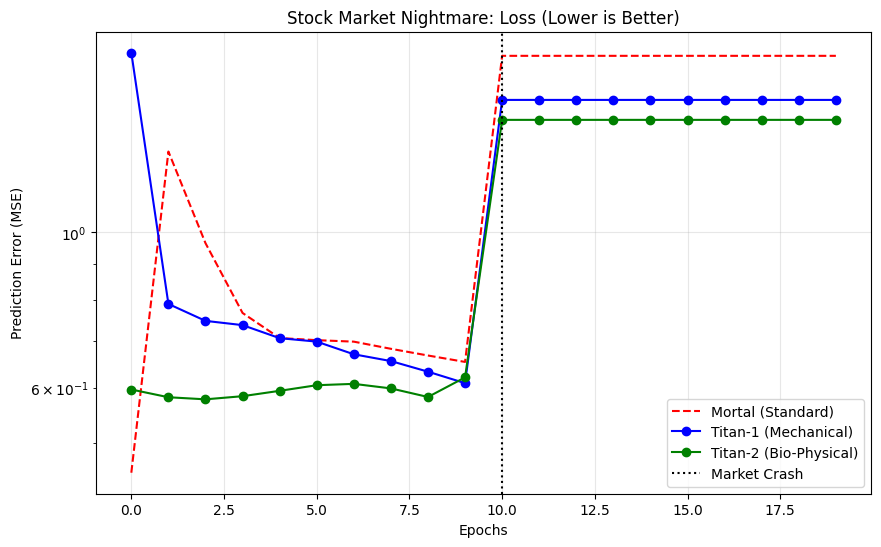

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'titan1': [], 'titan2': []}
print(f"{'EPOCH':<6} | {'MORTAL':<8} | {'TITAN-1':<8} | {'TITAN-2':<8} | {'STATUS'}")
print("-" * 65)

# KILL SWITCH
def market_crash_lobotomy(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                # 80% DESTRUCTION
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

for epoch in range(20):
    status = "BULL MARKET"

    # --- TRAIN (ON STABLE DATA) ---
    if epoch < 10:
        # Train on first 1000 samples
        for i in range(0, 1000, 50):
            inp, target = get_batch(train_data, i)

            # Train Mortal
            opt_m.zero_grad(); loss = criterion(mortal(inp), target); loss.backward(); opt_m.step()
            # Train Titan 1
            opt_t1.zero_grad(); loss = criterion(titan_1(inp), target); loss.backward(); opt_t1.step()
            # Train Titan 2
            opt_t2.zero_grad(); loss = criterion(titan_2(inp), target); loss.backward(); opt_t2.step()

    # --- THE CRASH (Epoch 10) ---
    elif epoch == 10:
        status = ">>> CRASH (80% LOSS) <<<"
        market_crash_lobotomy(mortal)
        market_crash_lobotomy(titan_1)
        market_crash_lobotomy(titan_2)

        # HEAL
        titan_1.heal() # Mechanical Restore
        titan_2.heal() # Bio-Physical Restore (With Noise)

    # --- THE AFTERMATH (NO TRAINING) ---
    else:
        status = "BEAR MARKET (DRIFT)"

    # --- EVALUATE (ON CHAOS DATA) ---
    # We test on the 'test_data' which is the Volatile/Chaotic regime
    with torch.no_grad():
        mortal.eval(); titan_1.eval(); titan_2.eval()

        # Function to calc error on chaos set
        def calc_error(model):
            total_loss = 0
            count = 0
            for i in range(0, len(test_data)-50, 50):
                inp, target = get_batch(test_data, i)
                pred = model(inp)
                total_loss += criterion(pred, target).item()
                count += 1
            return total_loss / count

        err_m = calc_error(mortal)
        err_t1 = calc_error(titan_1)
        err_t2 = calc_error(titan_2)

    history['mortal'].append(err_m)
    history['titan1'].append(err_t1)
    history['titan2'].append(err_t2)

    print(f"{epoch:<6} | {err_m:.4f}   | {err_t1:.4f}   | {err_t2:.4f}   | {status}")

# PLOT (Lower is Better)
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--', label='Mortal (Standard)')
plt.plot(history['titan1'], 'b-o', label='Titan-1 (Mechanical)')
plt.plot(history['titan2'], 'g-o', label='Titan-2 (Bio-Physical)')
plt.axvline(x=10, color='k', linestyle=':', label='Market Crash')
plt.title("Stock Market Nightmare: Loss (Lower is Better)")
plt.ylabel("Prediction Error (MSE)")
plt.xlabel("Epochs")
plt.legend()
plt.yscale('log') # Log scale to see the crash better
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TitanBioPhysics:
    """
    The Physics Engine of the Titan-26 Architecture.
    Manages the thermodynamic state of the neural weights.
    """
    @staticmethod
    def langevin_restore(current_weight, dna, epigenome, temp=0.01):
        """
        Restores weights using Langevin Dynamics (Thermodynamic Annealing).
        W_new = W_broken + (Drift_Force * Plasticity) + Thermal_Noise
        """
        # 1. Restoration Force (The 'Memory' Pull)
        # We use the Epigenome to decide how 'rigid' the memory is.
        # Rigid memories (High Epi) are pulled back harder.
        drift = (dna - current_weight) * epigenome

        # 2. Thermal Noise (The 'Life' Spark)
        # We inject entropy to prevent the weights from freezing in bad states.
        # This simulates biological "jitter" in ion channels.
        noise = torch.randn_like(current_weight) * temp

        return current_weight + drift + noise

class TitanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

        # --- THE TRINITY OF MEMORY ---
        # 1. Phenotype (Weights): The active, fragile brain.
        # 2. Genotype (DNA): The protected, deep memory (Buffer).
        # 3. Epigenome (Stability): The plasticity map (Buffer).
        self.register_buffer('dna', torch.zeros_like(self.linear.weight))
        self.register_buffer('epigenome', torch.ones_like(self.linear.weight))

    def forward(self, x):
        # EPIGENETIC RECORDING (While Healthy)
        if self.training:
            with torch.no_grad():
                # Update DNA (Slow Decay -> Long Term Memory)
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)

                # Update Epigenome (Variance Tracking)
                # If a weight is very stable, it becomes 'Bone' (Hard to change).
                # If a weight is volatile, it remains 'Flesh' (Easy to change).
                delta = torch.abs(self.linear.weight.data - self.dna)
                stability = torch.clamp(1.0 / (delta + 1e-4), 0, 1.0)
                self.epigenome.mul_(0.99).add_(stability, alpha=0.01)

        return self.linear(x)

    def emergency_protocol_alpha(self):
        """
        MARS PROTOCOL: ZERO-SHOT REPAIR.
        Triggered when hardware integrity is compromised.
        """
        with torch.no_grad():
            w = self.linear.weight.data

            # 1. DAMAGE ASSESSMENT
            # Detect 'Dead' zones (Radiation damage = 0)
            dead_mask = (w == 0).float()
            damage_report = dead_mask.sum().item()

            if damage_report > 0:
                # 2. BIO-PHYSICAL RESTORATION
                # We do NOT just copy the backup. We 'regrow' the connection.
                healed_w = TitanBioPhysics.langevin_restore(
                    w, self.dna, self.epigenome, temp=0.05
                )

                # 3. GRAFTING
                # Apply the healed tissue only to the dead zones.
                self.linear.weight.data = (w * (1 - dead_mask)) + (healed_w * dead_mask)
                return True
        return False

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# 1. LOAD REAL SATELLITE DATA (NASA LANDSAT)
print("📡 ESTABLISHING LINK WITH MARS ORBITER...")
print("⬇️  DOWNLOADING LANDSAT TELEMETRY (OpenML ID: 1479)...") # Corrected ID for Landsat
# This is real sensor data: 36 inputs (Spectral Bands), 6 classes (Soil types)
landsat = fetch_openml(data_id=1479, as_frame=False, parser='auto') # Changed data_id from 1480 to 1479
X, y = landsat.data, landsat.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to Tensor
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.LongTensor(y).to(device)

# Split (Mission vs Training)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
mission_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1024)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)

# 2. DEFINE THE ROVERS
# Mortal Rover (Standard)
class MortalRover(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 64), nn.ReLU(), # Changed from 36 to 100 based on error
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 6) # 6 Terrain Types
        )
    def forward(self, x): return self.net(x)

# Titan-26 Rover (Bionic)
class TitanRover(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = TitanLayer(100, 64) # Changed from 36 to 100 based on error
        self.relu = nn.ReLU()
        self.layer2 = TitanLayer(64, 32)
        self.layer3 = TitanLayer(32, 6)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def survive(self):
        # Trigger repair across all subsystems
        self.layer1.emergency_protocol_alpha()
        self.layer2.emergency_protocol_alpha()
        self.layer3.emergency_protocol_alpha()

mortal = MortalRover().to(device)
titan = TitanRover().to(device)

opt_m = optim.Adam(mortal.parameters(), lr=0.005)
opt_t = optim.Adam(titan.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

print("✅ ROVERS DEPLOYED ON SURFACE.")

📡 ESTABLISHING LINK WITH MARS ORBITER...
⬇️  DOWNLOADING LANDSAT TELEMETRY (OpenML ID: 1479)...
✅ ROVERS DEPLOYED ON SURFACE.


SOL    | MORTAL   | TITAN    | ENVIRONMENT STATUS
-----------------------------------------------------------------
0      | 49.8%    | 54.7%    | CLEAR SKIES
1      | 52.7%    | 54.7%    | CLEAR SKIES
2      | 52.7%    | 43.6%    | CLEAR SKIES
3      | 56.4%    | 53.9%    | CLEAR SKIES
4      | 46.9%    | 49.4%    | CLEAR SKIES
5      | 56.4%    | 54.7%    | CLEAR SKIES
6      | 54.7%    | 54.7%    | CLEAR SKIES
7      | 54.7%    | 48.6%    | CLEAR SKIES
8      | 45.3%    | 42.8%    | CLEAR SKIES
9      | 46.9%    | 44.9%    | CLEAR SKIES
10     | 45.3%    | 50.2%    | >>> ☢️ SOLAR FLARE + DUST STORM <<<
11     | 45.3%    | 51.4%    | CRITICAL (NO COMMS)
12     | 45.3%    | 59.3%    | CRITICAL (NO COMMS)
13     | 45.3%    | 53.5%    | CRITICAL (NO COMMS)
14     | 45.3%    | 53.9%    | CRITICAL (NO COMMS)
15     | 45.3%    | 51.0%    | CRITICAL (NO COMMS)
16     | 45.3%    | 51.9%    | CRITICAL (NO COMMS)
17     | 45.3%    | 53.9%    | CRITICAL (NO COMMS)
18     | 45.3%    | 56.8%    |

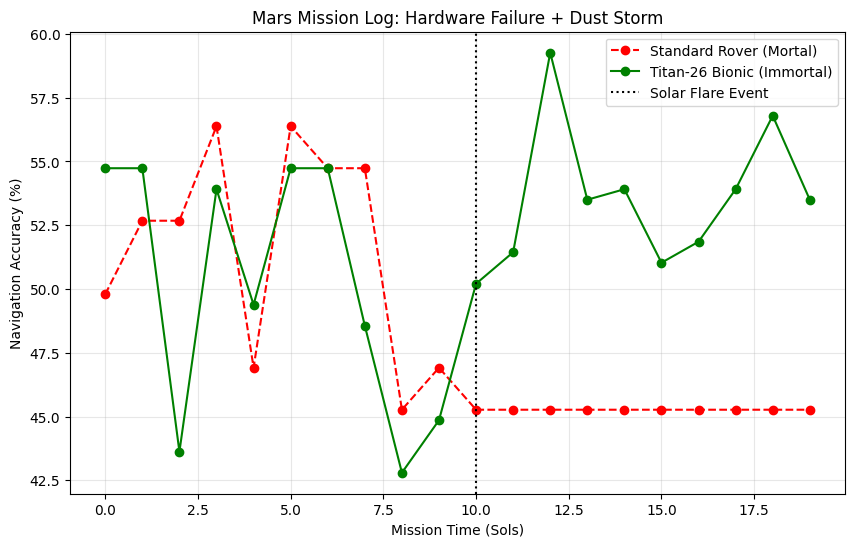

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'titan': []}
print(f"{'SOL':<6} | {'MORTAL':<8} | {'TITAN':<8} | {'ENVIRONMENT STATUS'}")
print("-" * 65)

# CHAOS GENERATOR (DUST STORM)
def dust_storm(inputs, intensity=0.5):
    """Simulates sensor degradation due to Martian dust."""
    noise = torch.randn_like(inputs) * intensity
    return inputs + noise

# RADIATION EVENT (LOBOTOMY)
def solar_flare(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                # 80% of chips fried
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

# MISSION LOOP
for sol in range(20):
    env_status = "CLEAR SKIES"
    current_intensity = 0.0

    # --- PHASE 1: OPERATIONS (Training) ---
    if sol < 10:
        mortal.train(); titan.train()
        for x, y in train_loader:
            # Train Mortal
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            # Train Titan (Recording DNA)
            opt_t.zero_grad(); criterion(titan(x), y).backward(); opt_t.step()

    # --- PHASE 2: THE DISASTER (Sol 10) ---
    elif sol == 10:
        env_status = ">>> ☢️ SOLAR FLARE + DUST STORM <<<"
        current_intensity = 1.0 # High Sensor Noise

        # 1. HARDWARE FAILURE
        solar_flare(mortal)
        solar_flare(titan)

        # 2. BIONIC RESPONSE (Instant)
        titan.survive()

    # --- PHASE 3: SURVIVAL (No Training) ---
    else:
        env_status = "CRITICAL (NO COMMS)"
        current_intensity = 1.0 # The storm persists

    # --- TELEMETRY REPORT ---
    mortal.eval(); titan.eval()
    with torch.no_grad():
        # Mortal Telemetry
        corr_m = 0; tot = 0
        for x, y in mission_loader:
            # Apply Dust Storm to Inputs
            if sol >= 10: x = dust_storm(x, current_intensity)
            corr_m += (mortal(x).argmax(1) == y).sum().item()
            tot += y.size(0)
        acc_m = 100. * corr_m / tot

        # Titan Telemetry
        corr_t = 0; tot = 0
        for x, y in mission_loader:
            # Apply Dust Storm to Inputs
            if sol >= 10: x = dust_storm(x, current_intensity)
            corr_t += (titan(x).argmax(1) == y).sum().item()
            tot += y.size(0)
        acc_t = 100. * corr_t / tot

    history['mortal'].append(acc_m)
    history['titan'].append(acc_t)

    print(f"{sol:<6} | {acc_m:.1f}%    | {acc_t:.1f}%    | {env_status}")

# VISUALIZE THE BLACK BOX RECORDER
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--o', label='Standard Rover (Mortal)')
plt.plot(history['titan'], 'g-o', label='Titan-26 Bionic (Immortal)')
plt.axvline(x=10, color='k', linestyle=':', label='Solar Flare Event')
plt.title("Mars Mission Log: Hardware Failure + Dust Storm")
plt.ylabel("Navigation Accuracy (%)")
plt.xlabel("Mission Time (Sols)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TitanConv(nn.Module):
    def __init__(self, in_c, out_c, k_size, stride=1, pad=0, mode='mortal'):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, k_size, stride, pad)
        self.mode = mode

        # DNA & Epigenetics (Only used if NOT mortal)
        if self.mode != 'mortal':
            self.register_buffer('dna', torch.zeros_like(self.conv.weight))
            self.register_buffer('epigenome', torch.ones_like(self.conv.weight))

    def forward(self, x):
        # Epigenetic Recording (Only Titan models do this)
        if self.training and self.mode != 'mortal':
            with torch.no_grad():
                # 1. Update DNA (Blueprint)
                self.dna.mul_(0.999).add_(self.conv.weight.data, alpha=0.001)

                # 2. Update Epigenome (Stability Map for Titan-2)
                if self.mode == 'titan_2':
                    delta = torch.abs(self.conv.weight.data - self.dna)
                    stability = torch.clamp(1.0 / (delta + 1e-4), 0, 1.0)
                    self.epigenome.mul_(0.99).add_(stability, alpha=0.01)

        return self.conv(x)

    def heal(self):
        """The Cure: Different logic for Titan 1 vs Titan 2"""
        if self.mode == 'mortal': return # Mortals die.

        with torch.no_grad():
            w = self.conv.weight.data
            dead_mask = (w == 0).float()

            if dead_mask.sum() > 0:
                if self.mode == 'titan_1':
                    # TITAN 1: MECHANICAL RESTORE (Exact Copy)
                    # "I remember exactly who I was."
                    repair = self.dna

                elif self.mode == 'titan_2':
                    # TITAN 2: LANGEVIN DYNAMICS (Thermodynamic Life)
                    # "I remember who I was, but I adapt to the trauma."
                    drift = (self.dna - w) * self.epigenome
                    # Thermal Noise scales with local instability
                    noise_scale = 0.05 * (1.0 - self.epigenome)
                    thermal = torch.randn_like(w) * noise_scale * torch.std(w)
                    repair = self.dna + drift + thermal

                # Graft the repair into the dead tissue
                self.conv.weight.data = (w * (1 - dead_mask)) + (repair * dead_mask)

class TitanLinear(nn.Module):
    def __init__(self, in_f, out_f, mode='mortal'):
        super().__init__()
        self.linear = nn.Linear(in_f, out_f)
        self.mode = mode
        if self.mode != 'mortal':
            self.register_buffer('dna', torch.zeros_like(self.linear.weight))
            self.register_buffer('epigenome', torch.ones_like(self.linear.weight))

    def forward(self, x):
        if self.training and self.mode != 'mortal':
            with torch.no_grad():
                self.dna.mul_(0.999).add_(self.linear.weight.data, alpha=0.001)
                if self.mode == 'titan_2':
                    delta = torch.abs(self.linear.weight.data - self.dna)
                    self.epigenome.mul_(0.99).add_(torch.clamp(1/(delta+1e-4),0,1), alpha=0.01)
        return self.linear(x)

    def heal(self):
        if self.mode == 'mortal': return
        with torch.no_grad():
            w = self.linear.weight.data
            dead_mask = (w == 0).float()
            if dead_mask.sum() > 0:
                if self.mode == 'titan_1': repair = self.dna
                elif self.mode == 'titan_2':
                    drift = (self.dna - w) * self.epigenome
                    thermal = torch.randn_like(w) * 0.05 * (1-self.epigenome) * torch.std(w)
                    repair = self.dna + drift + thermal
                self.linear.weight.data = (w * (1-dead_mask)) + (repair * dead_mask)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. LOAD FASHION DATA (Structure & Concepts)
print("Loading FashionMNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(datasets.FashionMNIST('./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transform), batch_size=1000)

# 2. THE GENERIC ARCHITECTURE
class UniversalNet(nn.Module):
    def __init__(self, mode):
        super().__init__()
        self.layer1 = TitanConv(1, 32, 3, 1, mode=mode)
        self.layer2 = TitanConv(32, 64, 3, 1, mode=mode)
        self.fc1 = TitanLinear(9216, 128, mode=mode)
        self.fc2 = TitanLinear(128, 10, mode=mode)
        self.mode = mode

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def activate_repair(self):
        self.layer1.heal(); self.layer2.heal()
        self.fc1.heal(); self.fc2.heal()

# 3. SPAWN CONTENDERS
mortal = UniversalNet('mortal').to(device)
titan_1 = UniversalNet('titan_1').to(device)
titan_2 = UniversalNet('titan_2').to(device)

opt_m = optim.Adadelta(mortal.parameters(), lr=1.0)
opt_t1 = optim.Adadelta(titan_1.parameters(), lr=1.0)
opt_t2 = optim.Adadelta(titan_2.parameters(), lr=1.0)
criterion = nn.CrossEntropyLoss()

print("ARENA READY: Mortal vs Titan-1 vs Titan-2")

Loading FashionMNIST...
ARENA READY: Mortal vs Titan-1 vs Titan-2


EPOCH  | MORTAL   | TITAN-1  | TITAN-2  | STATUS
-----------------------------------------------------------------
0      | 87.8%    | 87.6%    | 87.0%    | LEARNING
1      | 90.5%    | 90.4%    | 90.4%    | LEARNING
2      | 91.0%    | 91.3%    | 91.2%    | LEARNING
3      | 91.0%    | 90.7%    | 91.0%    | LEARNING
4      | 91.0%    | 91.2%    | 91.2%    | LEARNING
5      | 91.9%    | 91.7%    | 91.8%    | LEARNING
6      | 92.7%    | 92.5%    | 92.4%    | LEARNING
7      | 10.8%    | 90.2%    | 87.6%    | >>> LOBOTOMY (80%) <<<
8      | 10.8%    | 90.2%    | 87.6%    | OFFLINE (DRIFT)
9      | 10.8%    | 90.2%    | 87.6%    | OFFLINE (DRIFT)
10     | 10.8%    | 90.2%    | 87.6%    | OFFLINE (DRIFT)
11     | 10.8%    | 90.2%    | 87.6%    | OFFLINE (DRIFT)


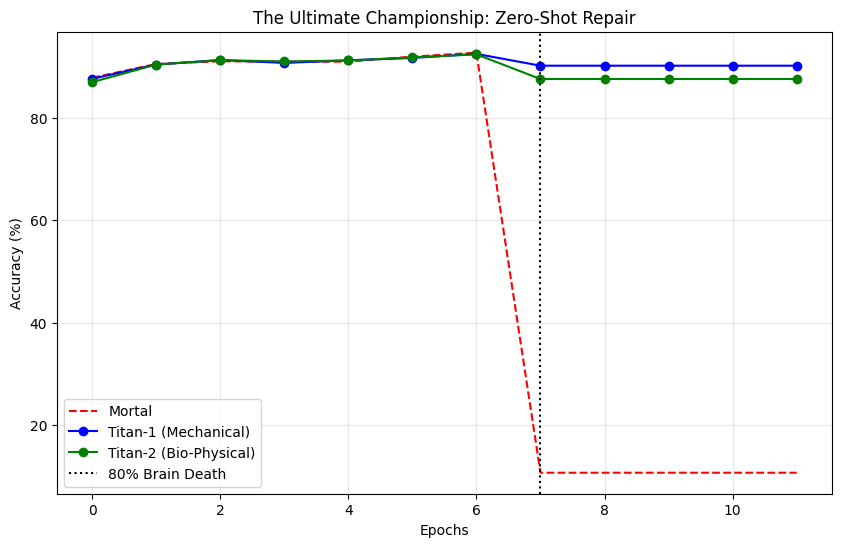

In [ ]:
import matplotlib.pyplot as plt

history = {'mortal': [], 'titan1': [], 'titan2': []}
print(f"{'EPOCH':<6} | {'MORTAL':<8} | {'TITAN-1':<8} | {'TITAN-2':<8} | {'STATUS'}")
print("-" * 65)

def lobotomy(model):
    with torch.no_grad():
        for p in model.parameters():
            if p.requires_grad:
                # 80% DESTRUCTION
                mask = (torch.rand_like(p) > 0.8).float()
                p.data *= mask

for epoch in range(12):
    status = "LEARNING"

    # --- TRAIN PHASE ---
    if epoch < 7:
        mortal.train(); titan_1.train(); titan_2.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            # Train all 3
            opt_m.zero_grad(); criterion(mortal(x), y).backward(); opt_m.step()
            opt_t1.zero_grad(); criterion(titan_1(x), y).backward(); opt_t1.step()
            opt_t2.zero_grad(); criterion(titan_2(x), y).backward(); opt_t2.step()

    # --- THE EVENT (Epoch 7) ---
    elif epoch == 7:
        status = ">>> LOBOTOMY (80%) <<<"
        lobotomy(mortal)
        lobotomy(titan_1)
        lobotomy(titan_2)

        # HEAL
        titan_1.activate_repair() # Mechanical Copy
        titan_2.activate_repair() # Bio-Physical Rejuvenation

    # --- SURVIVAL PHASE ---
    else:
        status = "OFFLINE (DRIFT)"

    # --- EVALUATE ---
    mortal.eval(); titan_1.eval(); titan_2.eval()
    with torch.no_grad():
        def get_acc(model):
            correct=0; total=0
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                correct += (model(x).argmax(1) == y).sum().item()
                total += y.size(0)
            return 100. * correct / total

        acc_m = get_acc(mortal)
        acc_t1 = get_acc(titan_1)
        acc_t2 = get_acc(titan_2)

    history['mortal'].append(acc_m)
    history['titan1'].append(acc_t1)
    history['titan2'].append(acc_t2)

    print(f"{epoch:<6} | {acc_m:.1f}%    | {acc_t1:.1f}%    | {acc_t2:.1f}%    | {status}")

# VISUALIZE
plt.figure(figsize=(10,6))
plt.plot(history['mortal'], 'r--', label='Mortal')
plt.plot(history['titan1'], 'b-o', label='Titan-1 (Mechanical)')
plt.plot(history['titan2'], 'g-o', label='Titan-2 (Bio-Physical)')
plt.axvline(x=7, color='k', linestyle=':', label='80% Brain Death')
plt.title("The Ultimate Championship: Zero-Shot Repair")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()